# 코로나19이후 화물차 사고감소를 위한 전용휴게시설 추가배치 제안





### 배경 및 목적

 - 코로나19 발생 이후, 비대면 소비활동이 증가하면서 택배물량이 크게 증가 => 화물차 기사들의 노동강도부담 또한 증가했을 것
 - 화물차의 고속도로 사고 증가 가능성 (특히 야간)
 - 정부는 화물차 고속도로 사고 감소를 위해 법안을 마련하고 졸음쉼터, 화물차전용휴게소, 화물차라운지, 마일리지 휴게소 등을 설치해왔음. 그러나, 실제로는, 화물차 기사가 이용하기에 여의치 않은 환경
 - 화물차의 고속도로 사고를 감소시키기 위해 전용 휴게 공간을 추가로 설치하면 어떨까?

## 개요


 - Step 1
1. 코로나19 진행 정도에 따른 택배물동량과 고속도로 화물차 통행량 분석
2. 고속도로 화물차 통행량과 사고량, 휴게소 개수의 상관관계 분석
 - Step 2
1. 고속도로 화물차 사고 법규위반별 사고 분석
2. 주간/야간 ‘안전운전불이행‘ 사고 분석
3. 시간대별 ‘안전운전불이행‘ 사고 분석
 - Step 3
1. 고속도로 노선별 화물차 ‘안전운전불이행’ 사고발생률 분석
 - Step 4
1. 사고발생률이 가장 높은 노선의 구간별 화물차 ‘안전운전불이행‘ 사고발생률 시각화 및 해당 노선의 졸음쉼터 및 휴게소 위치 시각화
2. 화물차 전용 휴게 시설 확충 지점 선정


In [1]:
# 파일 불러오기 및 전처리
import os
import pandas as pd
import glob
import numpy as np
from scipy import stats
# 지도
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import folium
from branca.element import Figure

# 한글 정보
from matplotlib import font_manager, rc 
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) 

## Step1 

## 1-1. 코로나19 진행 정도에 따른 택배물동량과 고속도로 화물차 통행량 분석

#### 2012-2020 연별 택배 물동량 전처리

In [2]:
annual_del = pd.read_excel('highway_traffic/step1_1/2012-2020 택배 물동량.xlsx',engine = 'openpyxl')
annual_del = annual_del.set_index('year')
annual_del.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2012년 to 2020년
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   물동량          9 non-null      int64  
 1   전년대비 증감율     9 non-null      float64
 2   2012년대비 증감율  9 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 288.0+ bytes


#### 월별 택배 물동량 전처리

In [3]:
# 파일 읽기
file_path2 = "highway_traffic/step1_1/2020-2021_월별_택배물동량.csv"
delivery = pd.read_csv(file_path2)
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년도        2 non-null      int64  
 1   합계        2 non-null      int64  
 2   1월        2 non-null      int64  
 3   2월        2 non-null      int64  
 4   3월        2 non-null      int64  
 5   4월        2 non-null      int64  
 6   5월        2 non-null      int64  
 7   6월        2 non-null      int64  
 8   7월        2 non-null      int64  
 9   8월        2 non-null      int64  
 10  9월        2 non-null      int64  
 11  10월       2 non-null      int64  
 12  11월       2 non-null      int64  
 13  12월       2 non-null      int64  
 14  단위 :  박스  0 non-null      float64
dtypes: float64(1), int64(14)
memory usage: 368.0 bytes


In [4]:
# 컬럼-인덱스 위치 변경
df = delivery.transpose()
# 불필요한 컬럼 삭제
df = df.drop(['단위 :  박스', '합계', '년도'])
#인덱스값 지정
df.index = ['01','02','03','04','05','06','07','08','09','10','11','12']
#컬럼명 지정
df.columns = ['2020','2021']

In [5]:
# 2020년, 2021 컬럼에 해당 년도 추가
m2020 = df['2020']
Y2020 = m2020.rename(index=lambda x: '2020' + x)
m2021 = df['2021']
Y2021 = m2021.rename(index=lambda x: '2021' + x)

In [6]:
#2020년, 2021년 한 컬럼에 합치기
df_series = pd.concat([Y2020, Y2021]) 
delivery = df_series.iloc[0:17].astype(int)

#### 코로나 바이러스 확진자수 전처리

In [7]:
# csv파일 읽기
file_path = "highway_traffic/step1_1/서울특별시 코로나19 확진자 발생동향.csv"
covid = pd.read_csv(file_path, encoding='cp949')
covid.head()
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   서울시 기준일  555 non-null    object
 1   전국 확진    555 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


In [8]:
# 서울시 기준일(날짜) 자료형 변경
str(covid['서울시 기준일'])
# 날짜 월별 형식으로 맞추기(2020.xx)
covid['서울시 기준일'] = covid['서울시 기준일'].apply(lambda x: str(x)[0:7])
# 점 제거 (2020.01 -> 202001)
covid['서울시 기준일'] = covid['서울시 기준일'].apply(lambda x: str(x).replace("." , ""))
# 같은 월끼리 전국확진자수 값 더하기 + 202001~202105 기간 정하기
covid = covid.groupby(['서울시 기준일'])['전국 확진'].sum().iloc[0:17]

#### 고속도로 통행량 2020-2021 전처리

In [9]:
# 병합한 파일 읽기
file_path4 = "highway_traffic/step1_1/전국_화물차_교통량_2020-21.csv"
traffic = pd.read_csv(file_path4, header=None)
traffic = traffic.iloc[1:,:]
# 컬럼명 지정
traffic.columns=['date','집계시','입출구구분코드','TCS하이패스구분코드','고속도로운영기관구분코드','영업형태구분코드','1종','2종','3종','4종','5종','6종','총쿄통량', 'null']
traffic.reset_index(inplace = True)

C:\Users\tndla\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
# 필요한 컬럼만 추출
traffic = traffic[['date','4종','5종']]
# 일별데이터를 월별 단위로 만들기
traffic['month'] = traffic['date'].apply(lambda x: str(x)[0:6])
# 화물차 4종,5종 합쳐서 total 컬럼에 넣기
traffic['total'] = traffic[['4종','5종']].sum(axis=1)
# 월별로 데이터 지정
traffic_final = traffic[['month','total']].groupby('month').sum().iloc[0:17]

In [11]:
traffic_final.iloc[:,0]

month
202001    2.195250e+08
202002    1.177344e+09
202003    9.255941e+10
202004    2.450240e+08
202005    2.425890e+08
202006    2.519474e+08
202007    2.435413e+08
202008    2.246535e+08
202009    2.604628e+08
202010    2.462170e+08
202011    2.690760e+08
202012    2.789780e+08
202101    2.472267e+08
202102    2.258994e+08
202103    2.857693e+08
202104    2.850891e+08
202105    2.700709e+08
Name: total, dtype: float64

### 2012년-2020년 년별 택배물동량 시각화

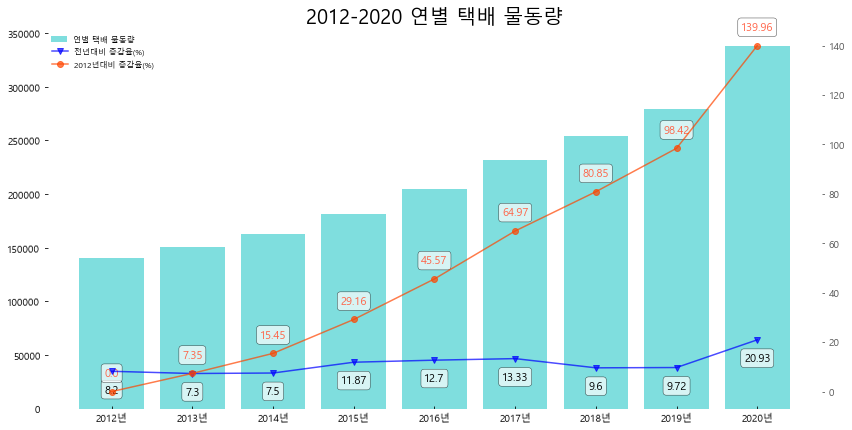

In [12]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
plt.rc('legend', fontsize = 8)
fig, ax1 = plt.subplots()
rc('font', family=font_name) 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
plt.rc('legend', fontsize = 8)
plt.rcParams['axes.unicode_minus'] = False

x = annual_del.index
y1 = annual_del['물동량']
y2 = round(annual_del['전년대비 증감율']*100, 2)
y3 = round(annual_del['2012년대비 증감율']*100, 2)

ax1.set_title('2012-2020 연별 택배 물동량', fontsize = 20)
ax1.bar(x, y1, color='c', linewidth=5, alpha=0.5, label='연별 택배 물동량')
ax1.tick_params(axis='both', direction='in', rotation=1)
ax1.patch.set_visible(False)
ax1.legend(loc=2, framealpha=0.0)
ax1.set_facecolor('white')
ax2 = ax1.twinx()
ax2.plot(x, y2, marker='v', color='blue', label='전년대비 증감율(%)', alpha=0.7, zorder = 10)
ax2.plot(x, y3, marker='o', color='orangered', label='2012년대비 증감율(%)', alpha=0.7, zorder = 11)
ax2.grid(False)
mybox={'facecolor':'white','edgecolor':'black','boxstyle':'round', 'alpha': 0.7}
for i, v in enumerate(x):
    ax2.text(v, y2[i]-5, y2[i],
             fontsize = 11, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='top',
             bbox = mybox)
for i, v in enumerate(x):
    ax2.text(v, y3[i]+5, y3[i],
             fontsize = 11, 
             color='tomato',
             horizontalalignment='center',  
             verticalalignment='bottom',
             bbox = mybox)   
ax2.tick_params(axis='y', direction='in')
ax2.legend(bbox_to_anchor=(0.15,0.97), framealpha=0.0)

 -  택배물동량은 2012년부터 2019년까지 매년 7~12%씩 성장했음
 -  코로나가 발생한 2020년부터는 2019년(9.72%) 대비 2배 이상의 증가율(20.93%)을 보임

### 코로나 - 월별 택배 물동량 시각화

([<matplotlib.axis.XTick at 0x1d5b327a490>,
 [Text(0, 0, '202001'),
  Text(2, 0, '202003'),
  Text(4, 0, '202005'),
  Text(6, 0, '202007'),
  Text(8, 0, '202009'),
  Text(10, 0, '202011'),
  Text(12, 0, '202101'),
  Text(14, 0, '202103'),
  Text(16, 0, '202105')])

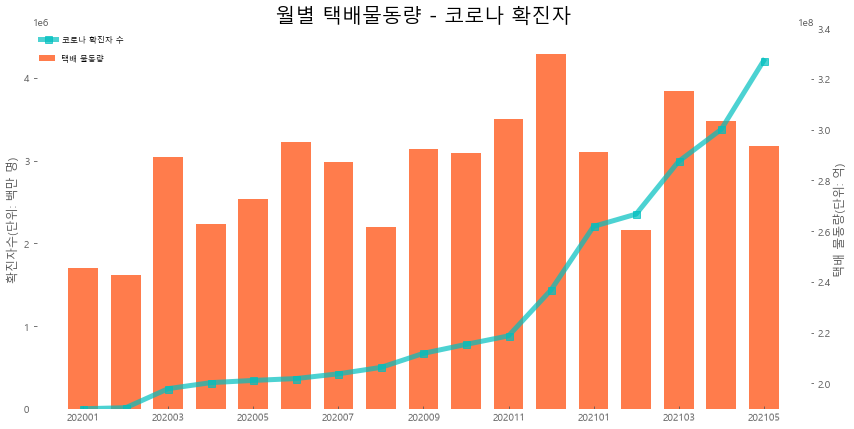

In [13]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
plt.rc('legend', fontsize = 8)
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

covid_x = covid.index
covid_y = covid.iloc[0:,]
delivery_x = delivery.index
delivery_y = delivery.iloc[0:,]

fig, ax1 = plt.subplots()
ax1.set_title('월별 택배물동량 - 코로나 확진자', fontsize = 20)
ax1.plot(covid_x, covid_y, '-s', color='c', markersize=7, linewidth=5, alpha=0.7, label='코로나 확진자 수')
ax1.set_ylim(0, 4600000)
ax1.set_ylabel('확진자수(단위: 백만 명)')
ax1.tick_params(axis='both', direction='in', rotation=1)
ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)
ax1.legend(loc=2, framealpha=0.0)
ax1.set_facecolor('white')
ax1.grid(False)
ax2 = ax1.twinx()
ax2.bar(covid_x, delivery_y, color='orangered', label='택배 물동량', alpha=0.7, width=0.7 )
ax2.set_ylim(190000000, 340000000)
ax2.set_ylabel('택배 물동량(단위: 억)')
ax2.tick_params(axis='y', direction='in')
ax2.legend(bbox_to_anchor=(0.1,0.95), framealpha=0.0)
plt.xticks(np.arange(0, 17, 2), labels=['202001', '202003', '202005','202007', '202009', '202011','202101','202103', '202105'])

- 2021년 2월, 택배 물동량이 급감. 이는 택배 파업과 설 연휴로 인한 배송 휴무가 원인인 것으로 파악됨
- 그럼에도 불구하고, 전년동월대비 7.4% 증가율을 보임
- 코로나 확진자수가 급격히 늘어나는 대유행시기(특히 11월→12월, 2월 →3월)에 택배 물동량도 급증하는 경향이 있음
- 코로나19 발생 이후, 비대면 소비활동의 증가로 택배물량이 크게 증가했음을 확인!

### 택배 물동량 - 화물차 교통량 상관관계 시각화

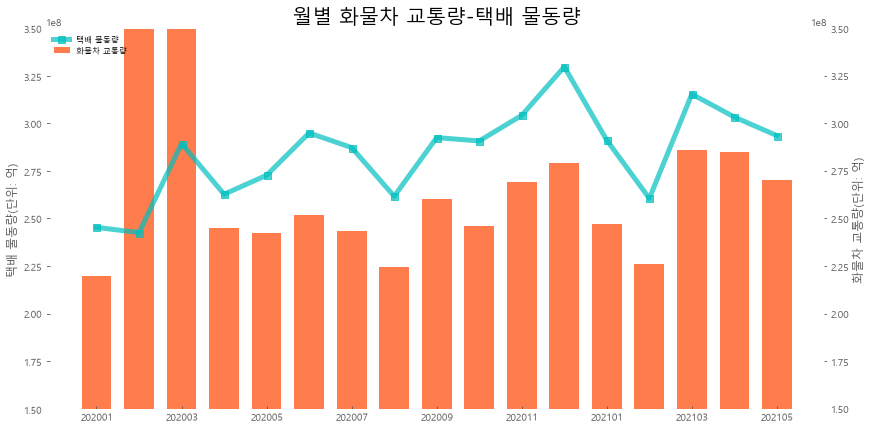

In [14]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

delivery_x = delivery.index
delivery_y = delivery.iloc[0:,]
traffic_x = traffic_final.index
traffic_y = traffic_final.iloc[:,0]

fig, ax1 = plt.subplots()
ax1.set_title('월별 화물차 교통량-택배 물동량', fontsize = 20)
ax1.plot(delivery_x, delivery_y, '-s', color='c', markersize=7, linewidth=5, alpha=0.7, label='택배 물동량')
ax1.set_ylim(150000000,350000000)
ax1.set_ylabel('택배 물동량(단위: 억)')
ax1.tick_params(axis='both', direction='in', rotation=1)
ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)
ax1.legend(loc=2, framealpha=0.0)
ax1.set_facecolor('gray')
ax1.grid(False)
ax2 = ax1.twinx()
ax2.bar(delivery_x, traffic_y, color='orangered', label='화물차 교통량', alpha=0.7, width=0.7 )
ax2.set_ylim(150000000, 350000000)
ax2.set_ylabel('화물차 교통량(단위: 억)')
ax2.tick_params(axis='y', direction='in')
ax2.legend(bbox_to_anchor=(0.113,0.97), framealpha=0.0)
plt.xticks(np.arange(0, 17, 2), labels=['202001', '202003', '202005','202007', '202009', '202011','202101','202103', '202105'])
plt.show()

- 2020~2021년 월별 화물차 교통량과 택배 물동량이 유사한 증감 추이를 보임
- 택배 물량이 늘어남에 따라 화물차 운전기사의 노동강도가 커짐을 확인!

## 1-2 고속도로 화물차 통행량과 사고량, 휴게소 개수의 상관관계 분석

#### 고속도로 통행량 데이터 불러오기

In [15]:
## 고속도로 통행량
# 2016 ~ 2019년 일별 고속도로 통행량.txt을 연 단위로 출력
# 2020년 월별 고속도로 통행량.xlsx를 연 단위로 합치기
path = 'highway_traffic/step1_2/traffic'
file_list = os.listdir(path)
df = pd.DataFrame()
df_excel = pd.DataFrame()
for f_nm in file_list:
    if '.txt' in f_nm:
        for_data = pd.read_csv(path + '/' + f_nm, sep = '|', encoding = 'UTF-8', header = None)
        for_data.columns = ['집계일자','입출구구분코드','TCS하이패스구분코드','고속도로운영기관구분코드','영업형태구분코드','1종교통량','2종교통량','3종교통량','4종교통량','5종교통량','6종교통량','총교통량', 'noname']
        for_data['year'] = f_nm[0:4]
        df = pd.concat([df, for_data], axis=0)
    elif '.xlsx' in f_nm:
        for_data = pd.read_excel(path + '/' + f_nm, engine = 'openpyxl')
        df_excel = pd.concat([df_excel, for_data], axis=0)

In [16]:
df.head()

,집계일자,입출구구분코드,TCS하이패스구분코드,고속도로운영기관구분코드,영업형태구분코드,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,noname,year
0,20160101,0,1,0,0,731449,7570,11197,9396,4637,11668,775917,NaN,2016
1,20160101,0,1,0,1,128213,1481,2187,1182,885,12337,146285,NaN,2016
2,20160101,0,1,2,0,37517,424,591,626,247,1697,41102,NaN,2016
3,20160101,0,1,1,0,40327,248,633,740,367,2239,44554,NaN,2016
4,20160101,0,1,8,0,32269,113,152,149,348,478,33509,NaN,2016


In [17]:
# df_excel 전처리
# df_excel 'year'컬럼에서 2020년만 추출
df_excel = df_excel.iloc[:,1:]
df_excel['year'] = df_excel['date'].apply(lambda x: str(x)[0:4])
df_excel = df_excel[df_excel['year'] != '2021']
# df와 열 기준으로 합칠 예정이므로 컬럼 지정
df_excel.columns = ['집계일자','4종교통량','5종교통량','year']

In [18]:
# df 에서 필요한 컬럼 추출
df_final = df[['4종교통량','5종교통량','year']]
# df와 df_excel 합치기
df_final = pd.concat([df_final, df_excel], axis=0)

In [19]:
## 화물차 종류는 4종과 5종. 고속도로 화물차 교통량의 합 구하기
# df_final 에서 화물차 종인 4종과 5종 차량의 
df_final['total'] = df_final[['4종교통량','5종교통량']].sum(axis=1)
df_final_h = df_final[['year','total']].groupby('year').sum()

df_final_h

,total
year,
2016,184656248
2017,181019346
2018,191319988
2019,190206148
2020,210343212


#### 연별 휴게소 데이터 불러오기

In [20]:
### 연별 휴게소 개수 2016 ~ 2020년 파일 불러오기
rest1 = pd.read_excel('highway_traffic/step1_2/rest/고속도로 휴게소 주차장 현황(2016년).xlsx', engine = 'openpyxl')
rest2 = pd.read_excel('highway_traffic/step1_2/rest/고속도로 휴게소 주차장 현황(2017년).xlsx', engine = 'openpyxl')
rest3 = pd.read_excel('highway_traffic/step1_2/rest/고속도로 휴게소 주차장 현황(2018년).xlsx', engine = 'openpyxl')
rest4 = pd.read_excel('highway_traffic/step1_2/rest/고속도로 휴게소 주차장 현황(2019년).xlsx', engine = 'openpyxl')
rest5 = pd.read_excel('highway_traffic/step1_2/rest/고속도로 휴게소 주차장 현황(2020년).xlsx', engine = 'openpyxl')
### 연별 졸음 쉼터 개수 파일 불러오기
rest6 = pd.read_excel('highway_traffic/step1_2/rest/졸음쉼터 설치현황 (2021).xlsx', engine = 'openpyxl')

In [21]:
# 졸음쉼터 연도별로 개수 나누기
rest6_2016 = rest6.loc[rest6['설치년도'] <= 2016].copy()
rest6_2017 = rest6.loc[rest6['설치년도'] <= 2017].copy()
rest6_2018 = rest6.loc[rest6['설치년도'] <= 2018].copy()
rest6_2019 = rest6.loc[rest6['설치년도'] <= 2019].copy()
rest6_2020 = rest6.loc[rest6['설치년도'] <= 2020].copy()

In [22]:
# 휴게소 연도 지정하기
rest1['year'] = '2016'
rest2['year'] = '2017'
rest3['year'] = '2018'
rest4['year'] = '2019'
rest5['year'] = '2020'
# 졸음쉼터 연도 지정하기
rest6_2016['year'] = '2016'
rest6_2017['year'] = '2017'
rest6_2018['year'] = '2018'
rest6_2019['year'] = '2019'
rest6_2020['year'] = '2020'

In [23]:
# 각 연도별로 졸음쉼터와 휴게소 개수 합치기
rest1 = pd.concat([rest1, rest6_2016],axis = 0)
rest2 = pd.concat([rest2, rest6_2017],axis = 0)
rest3 = pd.concat([rest3, rest6_2018],axis = 0)
rest4 = pd.concat([rest4, rest6_2019],axis = 0)
rest5 = pd.concat([rest5, rest6_2020],axis = 0)

In [24]:
# 전체 합치고 연도별로 개수 구하기
rest = pd.concat([rest1, rest2, rest3, rest4, rest5], axis=0)
rest_h = rest.groupby('year').size()

In [25]:
# 연도별 전용 휴게시설 개수
rest_h.iloc[0:,]

year
2016    392
2017    392
2018    423
2019    424
2020    427
dtype: int64

#### 고속도로 사고량 데이터 불러오기

In [26]:
## 전국 도별 고속도로 사고량 파일 불러오기
path = "highway_traffic/step1_2/accident"
files = glob.glob(path + '/' + '*.xlsx')

In [27]:
# 엑셀 파일명이 붙은 새로운 컬럼 생성하기 
acc = pd.concat([pd.read_excel(f).\
                 assign(filename=os.path.basename(f).split('.xlsx')[0]) for f in files])

In [28]:
# '사고번호'컬럼에서 연도만 추출해서 각각'year'컬럼에 저장
acc['year'] = acc['사고번호'].apply(lambda x: str(x)[0:4])
# 가해운전자 차종을 화물차로 필터링
acc1 = acc.loc[acc['가해운전자 차종'] == '화물'].copy()

In [29]:
# 연도별 고속도로 사고수 출력
acc_h = acc1.groupby('year').size()
acc_h

year
2016    1041
2017     913
2018     972
2019     969
2020     966
dtype: int64

### 사고량 - 교통량 - 휴게소 시각화

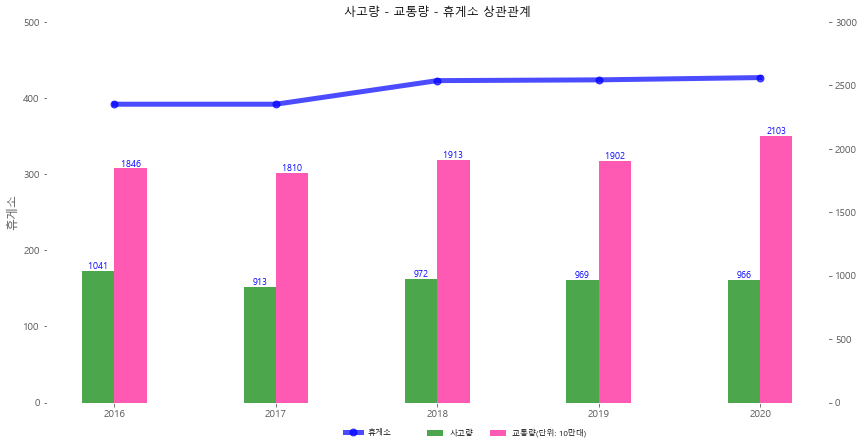

In [30]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
plt.rc('legend', fontsize = 8)

x = np.arange(5)
years = ['2016', '2017', '2018', '2019', '2020']
y1 = acc_h.iloc[0:,]
y2 = df_final_h.iloc[:,0] // 100000
y3 = rest_h.iloc[0:,]

fig, ax2 = plt.subplots()
ax1 = ax2.twinx()
ax1.set_facecolor('w')
ax1.bar(x-0.1, y1, color='green', width=0.2, alpha=0.7, label='사고량')
ax1.bar(x+0.1, y2, color='deeppink', width=0.2, alpha=0.7, label='교통량(단위: 10만대)')
ax1.legend(ncol=2, framealpha=0, bbox_to_anchor=(0.7, -0.05))
ax1.grid(False)
ax1.set_ylim(0,3000)

for i, v in enumerate(x):
    ax1.text(v-0.1, y1[i], y1[i],
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  
             verticalalignment='bottom') 
    ax1.text(v+0.1, y2[i], y2[i],
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  
             verticalalignment='bottom') 

ax2.plot(x,y3,color='blue', marker = 'o', markersize=7, linewidth=5, alpha=0.7, label='휴게소')
ax2.set_facecolor('w')
ax2.set_ylabel('휴게소')
ax2.grid(False)
ax2.legend(framealpha=0, bbox_to_anchor=(0.45, -0.05))
ax2.set_ylim(0,500)

plt.xticks(x,years)
plt.xlabel('연도')
plt.title("사고량 - 교통량 - 휴게소 상관관계", fontsize=12)
plt.show()

- 코로나가 발생한 2020년, 화물차 교통량이 크게 상승
: 예년과 달리 2억을 훌쩍 넘김
- 반면, 화물차 사고량은 조금씩 감소하는 추세임

### 사고율 - 휴게소 시각화

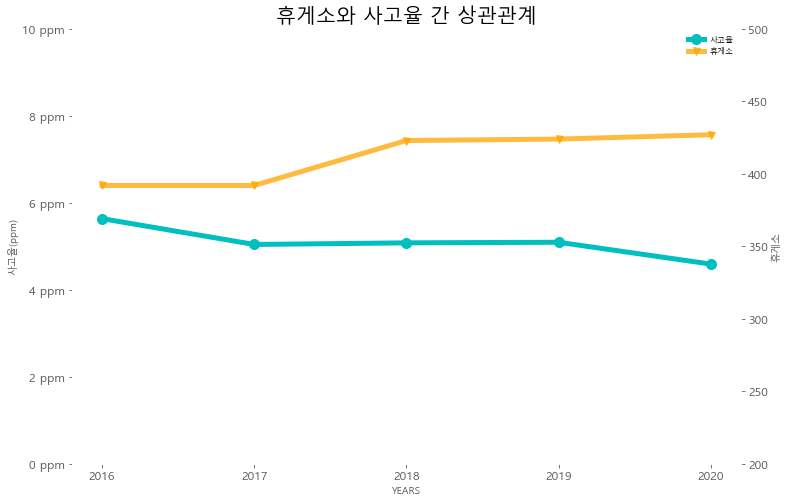

In [31]:
# 휴게소 - 사고량/교통량 #
x = np.arange(5)
years = ['2016', '2017', '2018', '2019', '2020']

y1 = rest_h.iloc[0:,]
y2 = (acc_h.iloc[0:,]) / (df_final_h.iloc[:,0]) * 1000000
y3 = y2.pct_change()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rc('legend', fontsize = 8)


fig, ax1 = plt.subplots()
ax1.set_facecolor('w')
line1 = ax1.plot(x, y2, color='c', 
                 marker = 'o', markersize=10, 
                 linewidth=5, label='사고율')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i ppm'))
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%i 년'))
ax1.set_ylim(0,10)
ax1.set_xlabel('YEARS', fontsize=10)
ax1.set_ylabel('사고율(ppm)', fontsize=10)


ax2 = ax1.twinx()
line2 = ax2.plot(x,y1,color='orange', 
                 marker = 'v', markersize=7, linewidth=5, 
                 alpha=0.75,
                 label='휴게소')
ax2.set_ylim(200,500)
ax2.set_ylabel('휴게소', fontsize=10)
ax2.grid(False)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', framealpha = 0)
ax1.set_title('휴게소와 사고율 간 상관관계', fontsize = 20)
plt.xticks(x,years)
plt.show()

- 휴게소가 증가함에 따라 사고율은 점차 감소하는 추세

### 이는 곧, 휴게 시설의 꾸준한 증가가 화물차 사고 감소에 긍정적 영향을 미치고 있는 것!

## Step2

## 2-1. 고속도로 화물차 사고 법규위반별 사고 분석

In [32]:
# 파일 불러오기
file = 'highway_traffic/step2/2018_2020_고속도로_화물차_사고분석.xlsx'
df_accident = pd.read_excel(file, engine='openpyxl')

In [33]:
# 컬럼명 지정
columns=['사고번호','사고일시','시군구','사고내용','사망자수','중상자수','경상자수',
         '부상신고자수','법규위반','가해운전자 차종']
df_accident = df_accident[columns]

In [34]:
# 가해운전자 차종: '특수' 제외
df_accident = df_accident[df_accident['가해운전자 차종']!='특수']

In [35]:
# 고속도로 화물차 사고 법규위반별 사고량 분석
accident_type = df_accident['법규위반'].value_counts().keys().tolist()
count = df_accident['법규위반'].value_counts().tolist()

### 고속도로 화물차 법규위반별 사고 건수 시각화

Text(0.5, 1.0, '고속도로 화물차 법규위반별 사고 건수')

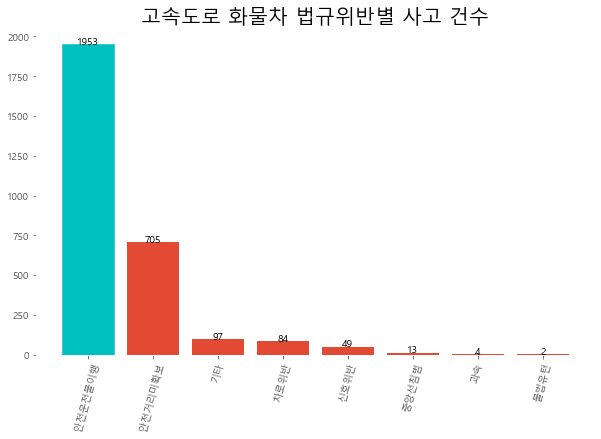

In [36]:
plt.style.use('ggplot')  
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
xtick_label_position = list(range(len(accident_type)))
plt.xticks(xtick_label_position, accident_type,fontsize=10, rotation=75)
bars = plt.bar(xtick_label_position, count)
bars[0].set_color('c')  

for i, bar in enumerate(bars):
    ax.text(bar.get_x()+bar.get_width()*1/2,
            bar.get_height()+1,
            count[i],
            ha = 'center',
            fontsize = 10)

ax.set_facecolor('w')
plt.title('고속도로 화물차 법규위반별 사고 건수', size=20)

- 졸음운전과 밀접한 연관이 있는 ‘안전운전불이행’ 사고(1953건)이
다른 유형의 사고보다 월등히 많이 발생했음
- 졸음운전이 고속도로 화물차 사고의 가장 큰 원인일 가능성이 높음
: 기존에 이루어진 분석 결과들과 동일

- 그러면 안전운전불이행 사고에 초점을 맞출 필요가 있네!

## 2-2. 주간/야간 ‘안전운전불이행‘ 사고 분석

In [37]:
# 주간/야간에 따른 '안전운전불이행' 사고 분석
# 주간: 오전 6시~ 야간: 오후 6시~
accident_safety = df_accident[df_accident['법규위반']=='안전운전불이행'].copy()
dates = accident_safety['사고일시'].str.split(' ')
accident_safety['시간대'] = dates.str.get(3)
accident_safety['시간대'] = accident_safety['시간대'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', 
                                                          repl= r'', regex=True)
accident_safety['시간대'] = accident_safety['시간대'].astype('int')

In [38]:
daynight = []
for i in range(len(accident_safety)):
    if 6 <= accident_safety.iloc[i]['시간대'] < 18:
        daynight.append('주간')
    else:
        daynight.append('야간')

accident_safety['주야'] = daynight

In [39]:
accident_safety.head()

,사고번호,사고일시,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,법규위반,가해운전자 차종,시간대,주야
0,2018010300100425,2018년 1월 3일 20시,강원도 원주시 판부면,경상사고,0,0,1,0,안전운전불이행,화물,20,야간
1,2018010900100012,2018년 1월 9일 00시,강원도 홍천군 화촌면,사망사고,1,0,0,0,안전운전불이행,화물,0,야간
2,2018012000100433,2018년 1월 20일 19시,강원도 춘천시 남면,중상사고,0,1,2,0,안전운전불이행,화물,19,야간
3,2018021500100140,2018년 2월 15일 09시,강원도 평창군 대관령면,중상사고,0,6,0,0,안전운전불이행,화물,9,주간
5,2018041100100011,2018년 4월 11일 00시,강원도 원주시 신림면,경상사고,0,0,1,0,안전운전불이행,화물,0,야간


In [40]:
# 주간/야간 안전운전불이행 사고건수 차이
accident_safety['주야'].value_counts()

주간    1233
야간     720
Name: 주야, dtype: int64

### 주간/야간 안전운전불이행 사고 건수 비율 시각화

Text(0.5, 1.0, '주간/야간 안전운전불이행 사고 건수 비율')

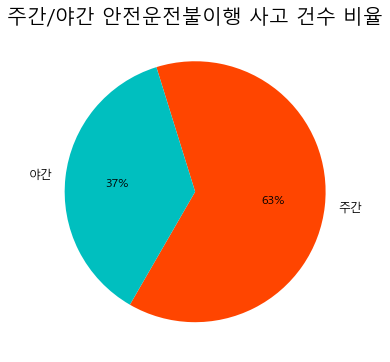

In [41]:
label = accident_safety['주야'].value_counts().index.tolist()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
pie = ax.pie(accident_safety['주야'].value_counts().values.tolist(), labels=label, autopct='%.0f%%',
             startangle=240, colors=['orangered','c'], textprops={'fontsize':12})
plt.title('주간/야간 안전운전불이행 사고 건수 비율', size=20)

- 전체 사고 중 63%가 주간(06 ~ 17시)에, 37%가 야간(18시 ~ 05시)에 발생했음
- 야간보다 주간에 절대적인 통행량이 많아서 그런 것이 아닐까?
- 통행량 대비 사고 수를 살펴볼 필요가 있음


## 2-3. 시간대별 '안전운전불이행' 사고 분석

In [42]:
# 시간대별 사고발생률(사고건수/통행량x10000) 파악을 위한 데이터 전처리
time_accident = accident_safety['시간대'].value_counts().sort_index()

In [43]:
# 시간대별 화물차(4종, 5종) 통행량
time_amount = pd.read_excel('highway_traffic/step2/2018_2020_시간대별_교통량.xlsx', engine='openpyxl')
time_amount.head()

,영업소,연도,시간대,1종입구,2종입구,3종입구,4종입구,5종입구,1종출구,2종출구,3종출구,4종출구,5종출구
0,개방식,2020,0,2297399,72996,42823,90464,78345,2760260,75485,58758,98290,86300
1,개방식,2020,1,1447717,75370,34704,85141,82497,1712190,82188,37047,88082,86162
2,개방식,2020,2,1049264,91107,39346,73708,89784,1190251,88405,33828,92177,99905
3,개방식,2020,3,1027184,120287,52773,81920,131985,1003077,102932,42328,101657,130581
4,개방식,2020,4,1920261,163081,95725,128242,228828,1351781,132519,64679,133804,200486


In [44]:
time_amount = time_amount[['영업소','시간대','4종입구','4종출구','5종입구','5종출구']]

time_amount2 = time_amount.groupby('시간대').mean()
time_amount2['평균통행량'] = (time_amount2['4종입구']+time_amount2['4종출구']+\
    time_amount2['5종입구']+time_amount2['5종출구'])/4
time_amount2.reset_index(inplace=True)

#### 2018 ~ 2020년 시간대별 화물차(4종, 5종) 통행량

In [45]:
# 파일 읽어오기
time_amount = pd.read_excel('highway_traffic/step2/2018_2020_시간대별_교통량.xlsx', engine='openpyxl')

In [46]:
# 전처리
time_amount = time_amount[['영업소','시간대','4종입구','4종출구','5종입구','5종출구']]

time_amount2 = time_amount.groupby('시간대').mean()
time_amount2['평균통행량'] = (time_amount2['4종입구']+time_amount2['4종출구']+\
    time_amount2['5종입구']+time_amount2['5종출구'])/4
time_amount2.reset_index(inplace=True)
avg_amount = time_amount2['평균통행량']

In [47]:
# 시간대별 사고건수와 평균통행량 데이터프레임
time_acc_amt = pd.concat([time_accident, avg_amount], axis=1)
time_acc_amt.rename(columns={'시간대':'사고건수'}, inplace=True)

In [48]:
# 사고발생률(사고건수/평균통행량x10000)(만분율 ‱)
time_acc_amt['사고발생률'] = time_acc_amt['사고건수']/time_acc_amt['평균통행량'] * 10000

In [49]:
time_acc_amt

,사고건수,평균통행량,사고발생률
0,48,3.052397e+05,1.572535
1,49,2.684000e+05,1.825634
2,49,2.850070e+05,1.719256
3,40,3.540082e+05,1.129917
4,62,5.371623e+05,1.154213
5,70,8.449453e+05,0.828456
6,67,1.102605e+06,0.607652
7,75,1.148848e+06,0.652828
8,100,1.251269e+06,0.799189
9,78,1.439677e+06,0.541788


In [50]:
# 6시~9시, 10시~13시, 14시~17시, 18시~21시, 22시~1시, 2시~5시로 시간대 구분
time_acc_amt.loc[0:2,'시간대'] = '22시~1시'
time_acc_amt.loc[2:6,'시간대'] = '2시~5시'
time_acc_amt.loc[6:10,'시간대'] = '6시~9시'
time_acc_amt.loc[10:14,'시간대'] = '10시~13시'
time_acc_amt.loc[14:18,'시간대'] = '14시~17시'
time_acc_amt.loc[18:22,'시간대'] = '18시~21시'
time_acc_amt.loc[22:24,'시간대'] = '22시~1시'

In [51]:
# 시간대별 평균 사고발생률
avg_acc = time_acc_amt.groupby('시간대').mean()['사고발생률'].round(3)
avg_acc = avg_acc.reindex(index=['6시~9시','10시~13시','14시~17시','18시~21시','22시~1시','2시~5시'])

In [52]:
avg_acc

시간대
6시~9시      0.650
10시~13시    0.826
14시~17시    1.204
18시~21시    1.581
22시~1시     1.466
2시~5시      1.208
Name: 사고발생률, dtype: float64

### 시간대별 안전운전불이행 사고발생률 시각화

Text(0.5, 1.0, '시간대별 안전운전불이행 사고발생률')

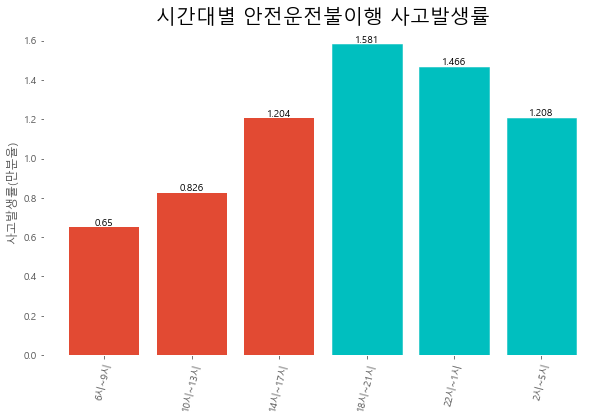

In [53]:
# 막대그래프
plt.style.use('ggplot')  
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
xtick_label_position = list(range(len(avg_acc)))
plt.xticks(xtick_label_position, avg_acc.index, fontsize=10, rotation=75)
plt.ylabel('사고발생률(만분율)')
bars = plt.bar(xtick_label_position, avg_acc)
bars[3].set_color('c')  
bars[4].set_color('c')  
bars[5].set_color('c')  

for i, bar in enumerate(bars):
    ax.text(bar.get_x()+bar.get_width()*1/2,
            bar.get_height()+0.01,
            avg_acc[i],
            ha = 'center',
            fontsize = 10)

ax.set_facecolor('w')
plt.title('시간대별 안전운전불이행 사고발생률', size=20)


### 시간대별 안전운전불이행 사고발생률의 비율 시각화

Text(0.5, 1.0, '시간대별 안전운전불이행 사고발생률의 비율')

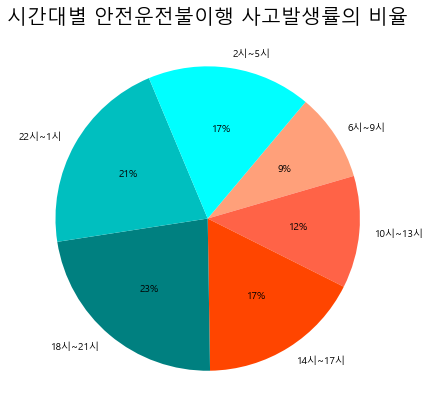

In [54]:
# 파이그래프(전체사고발생률 파이에서 각 시간대의 사고발생률이 차지하는 비율)
color = ['lightsalmon','tomato','orangered','teal','c','aqua']
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
pie = ax.pie(avg_acc, labels=avg_acc.index, colors=color,
             autopct='%.0f%%', startangle=50, counterclock=False, textprops={'fontsize':10})
plt.title('시간대별 안전운전불이행 사고발생률의 비율', size=20)

- 예상대로, 주간 시간대보다 야간 시간대에서 전반적으로 사고발생률이 높음
: 특히, 18시 ~ 21시, 22시 ~ 01시에서 사고발생률의 비율이 높음
- 14시 ~ 17시와 02시 ~ 05시의 사고발생률이 비슷함
: 점심식사 후 식곤증이 유발하는 졸음이 심야에 경험하는 졸음만큼이나 심각한 영향을 미치는 것일 수 있음

### 시간대별 안전운전불이행 사망자 비율 시각화

In [55]:
# 시간대별 사망자 수
dead = pd.DataFrame()
dead = pd.pivot_table(accident_safety, index='시간대', values='사망자수', aggfunc='sum')

In [56]:
# 'time_acc_amt'와 'dead'를 합치고 시간대별 사망자수 출력
dead = pd.concat([time_acc_amt, dead], axis=1)
dead = dead[['시간대','사망자수']]
dead = dead.groupby('시간대').sum()
dead = dead.reindex(index=['6시~9시','10시~13시','14시~17시','18시~21시','22시~1시','2시~5시'])

Text(0.5, 1.0, '시간대별 안전운전불이행 사망자 비율')

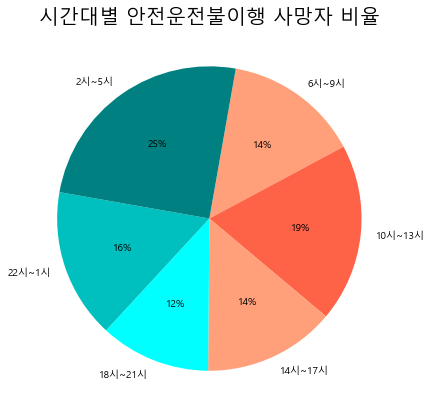

In [57]:
# 시간대별 사망자 수 파이그래프
color = ['lightsalmon','tomato','lightsalmon','aqua','c','teal']
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
pie = ax.pie(dead['사망자수'], labels=dead.index, colors=color,
             autopct='%.0f%%', startangle=80, counterclock=False, textprops={'fontsize':10})
plt.title('시간대별 안전운전불이행 사망자 비율', size=20)

- 전체 사망자 중 53%가 야간 사고, 
47%가 주간 사고로 인해 사망함
- T-test 분석 결과, 야간 사고 평균 사망자 수가
주간 사고 평균 사망자 수보다 더 많았으며,
이는 통계적으로 유의함 (t=-5.269, p=.000)
- 02시 ~ 05시의 경우, 사고발생률은 다른 야간 시간대에
비해 낮았으나 사망자 비율은 가장 높음
: 심야 시간의 졸음운전 사고는 더욱 치명적임

## Step3

## 3-1. 고속도로 노선별 화물차 ‘안전운전불이행’ 사고발생률 분석

In [58]:
# 1. 2020_노선별 화물차 평균일교통량 파일 불러오기
No_2020 = pd.read_excel("highway_traffic/step3/2020_노선별 화물차 평균일교통량.xlsx")
# 2. 2019_노선별 화물차 평균일교통량 파일 불러오기
No_2019 = pd.read_excel("highway_traffic/step3/2019_노선별 화물차 평균일교통량.xlsx")
# 3. 2018_노선별 화물차 평균일교통량 파일 불러오기
No_2018 = pd.read_excel("highway_traffic/step3/2018_노선별 화물차 평균일교통량.xlsx")

# 4. 노선별 안전불이행 사고량 불러오기
path = 'highway_traffic/step3/노선별 안전불이행 사고량'
file_list = os.listdir(path)

df_acc = pd.DataFrame()
for f_nm in file_list:
    for_data = pd.read_excel(path + '/' + f_nm)
    for_data['노선명'] = f_nm.split(' ')[0]
    for_data = for_data.groupby('노선명')['사고번호'].count()    
    df_acc = pd.concat([df_acc, for_data], axis=0)
df_acc = pd.DataFrame(df_acc)
df_acc.reset_index(inplace=True)
df_acc.columns = ['노선명','사고건수']

df_acc['노선명'] = df_acc['노선명'].apply(lambda x: '수도권제1순환선' if x == '서울외곽순환선' else x)

In [59]:
# 2018년 전처리
No_2018=No_2018.set_index('노 선 명')
No_name2=No_2018.loc['목 포 - 신의주':].index.tolist()
No_2018.drop(No_name2,inplace=True)
a = No_2018['화물차'].astype('int')
a = pd.DataFrame(a)
a.reset_index(inplace=True, drop=False)
a.columns = ['노선명','y2018']
# 수도권 제1순환선 & 서울외곽순환선 합산 전처리
a['노선명'] = a['노선명'].apply(lambda x: '수도권제1순환선(북부)' if x == '서울외곽순환선(북부)' else x)
a['노선명'] = a['노선명'].apply(lambda x: '수도권제1순환선(남부)' if x == '서울외곽순환선(남부)' else x)
 
# 2019년 전처리
No_2019=No_2019.set_index('노선명')
No_name1=No_2019.loc['목포-신의주':].index.tolist()
No_2019.drop(No_name1,inplace=True)
b = No_2019['화물차']
b = pd.DataFrame(b)
b.reset_index(inplace=True, drop=False)
b.columns = ['노선명','y2019']
# 수도권 제1순환선 & 서울외곽순환선 합산 전처리
b['노선명'] = b['노선명'].apply(lambda x: '수도권제1순환선(북부)' if x == '서울외곽순환선(북부)' else x)
b['노선명'] = b['노선명'].apply(lambda x: '수도권제1순환선(남부)' if x == '서울외곽순환선(남부)' else x)

# 2020년 전처리
No_2020=No_2020.set_index('노선명')
No_2020.loc['목 포 - 신의주':]
No_name=No_2020.loc['목 포 - 신의주':].index.tolist()
No_2020.drop(No_name,inplace=True)
c = No_2020['화물차']
c = pd.DataFrame(c)
c.reset_index(inplace=True, drop=False)
c.columns = ['노선명','y2020']

In [60]:
# 2018년 ~ 2020년 병합 및 합산
df = pd.merge(pd.merge(a, b, on = '노선명', how = 'outer'), c, on = '노선명', how = 'outer')
df['total'] = df[['y2018', 'y2019', 'y2020']].sum(axis=1)
df['노선명'] = df['노선명'].apply(lambda x: '수도권제1순환선' if x == '수도권제1순환선(북부)' or x == '수도권제1순환선(남부)' else x)
df['노선명'] = df['노선명'].apply(lambda x: '수도권제2순환선' if x == '수도권제2순환선(봉담)' or x == '수도권제2순환선(인천)' else x)
df = pd.DataFrame(df.groupby('노선명')['total'].sum())
df.reset_index(inplace=True)

# 경부 고속도로 -> 경부선
df_acc['노선명'] = df_acc['노선명'].apply(lambda x : '경부선' if x == '경부고속도로' else x)

In [61]:
df_acc_result = pd.merge(df, df_acc, on = '노선명', how = 'outer')
df_acc_result = df_acc_result[df_acc_result['사고건수'].isna() == False]
df_acc_result['사고발생률'] = list(map(lambda x, y : (x * 1000) /y, df_acc_result['사고건수'], df_acc_result['total']))

df_acc_result

,노선명,total,사고건수,사고발생률
0,강일춘천선,23289,10.0,0.429387
1,경부선,77006,362.0,4.700932
2,경인선,98336,14.0,0.142369
3,고창담양선,15787,6.0,0.380060
4,광주대구선,16376,15.0,0.915975
5,광주원주선,19900,3.0,0.150754
6,구리포천선,35843,24.0,0.669587
7,남해선,40124,58.0,1.445519
10,논산천안선,41988,7.0,0.166714
11,당진영덕선,24638,38.0,1.542333


In [62]:
df_acc_result.sort_values(by=['사고발생률'], ascending=False, inplace=True)
way_list = df_acc_result['노선명'].tolist()
x_pos = np.arange(len(way_list))

### 고속도로 노선별 화물차 사고발생률 시각화

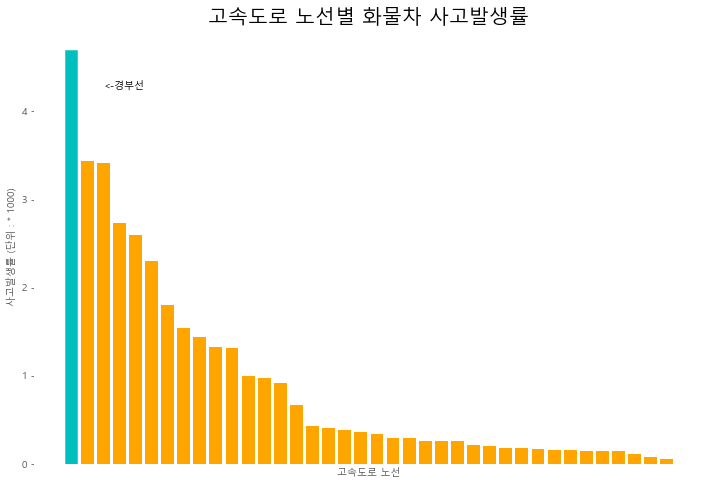

In [63]:
bar_list=plt.bar(x_pos, df_acc_result['사고발생률'], color = 'orange')
bar_list[0].set_color('c')
plt.title('고속도로 노선별 화물차 사고발생률',fontsize=20)
plt.xlabel('고속도로 노선', fontsize=10)
plt.ylabel('사고발생률 (단위 : * 1000)', fontsize=10) 
plt.text(2.0, 4.25, '<-경부선')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.set_facecolor('w')## 3 데이터 불러오기
plt.show()

- 39개 노선 중, 경부선의 ‘안전운전불이행’ 사고발생률(4.701‰)이
가장 높았음
- 경부선에 초점을 맞추어, 
어느 구간의 사고발생률이 높은지, 휴게 시설의 분포는 어떤지 살펴보자 !

## Step4 

## 4-1. 경부선의 구간별 화물차 ‘안전운전불이행‘ 사고발생률 시각화 및 졸음쉼터 및 휴게소 위치 시각화

#### 상행선

In [64]:
slp_rest = pd.read_csv('highway_traffic/step4/전국졸음쉼터.csv', encoding='cp949')

# 경부상행선 화물차 마일리지 졸음쉼터 위도,경도,이름 가져오기.
mask1 = (slp_rest.도로노선명 == '경부선') & (slp_rest.도로노선방향 == '부산기점 + 서울종점')
KBslp_up=slp_rest.loc[mask1,:][:9]

s_X=KBslp_up[['위도','경도']].iloc[:,0].tolist()
s_Y=KBslp_up[['위도','경도']].iloc[:,1].tolist()
s_name = KBslp_up['졸음쉼터명'].tolist()
KBslp_up[['위도','경도','졸음쉼터명']].head()

,위도,경도,졸음쉼터명
6,36.336267,127.528576,옥천*
7,36.271723,127.740733,청성*
9,36.210987,127.988545,추풍령*
11,36.156607,128.026307,봉산*
13,36.152787,128.190874,대신*


In [65]:
# 경부상행선 일반 졸음쉼터 위도, 경도, 이름 가져오기.
ns_X = slp_rest.loc[mask1,:][9:15][['위도','경도']].iloc[:,0].tolist()
ns_Y=slp_rest.loc[mask1,:][9:15][['위도','경도']].iloc[:,1].tolist()
ns_name =slp_rest.loc[mask1,:][9:15]['졸음쉼터명'].tolist()
slp_rest.loc[mask1,:][9:15][['위도','경도','졸음쉼터명']].head()

,위도,경도,졸음쉼터명
22,35.752413,129.194688,내남
24,35.545241,129.119023,삼남
26,35.342436,129.042567,양산
28,37.155403,127.086811,오산
30,37.001136,127.151958,원곡


In [66]:
# 경부선 일반 휴게소 좌표 가져오기
KB_rest = pd.read_csv('highway_traffic/step4/경부선휴게소좌표.csv')
KB_rest.head() 

,휴게소명,노선,위도,경도
0,건천(부산)*,경부선,35.830716,129.109310
1,건천(서울)*,경부선,35.831894,129.109244
2,경산(서울)*,경부선,35.879323,128.810331
3,경주(부산),경부선,35.724761,129.192950
4,금강(부산)*,경부선,36.279148,127.672231


In [67]:
# up_rest (경부 상행선 휴게소이름) 변수 지정
up_rest=['건천(서울)*', '경산(서울)*','김천(서울)*','신탄진(서울)*','안성(서울)','양산(서울)','언양(서울)','옥천(서울)*',\
         '입장거봉포도(서울)*','죽암(서울)*','죽전(서울)','천안삼거리(서울)*','청주(서울)*','추풍령(서울)','칠곡(서울)*',\
        '황간(서울)*']

KB_rest=KB_rest.set_index('휴게소명')
KB_rest.loc[up_rest].head()

,노선,위도,경도
휴게소명,,,
건천(서울)*,경부선,35.831894,129.109244
경산(서울)*,경부선,35.879323,128.810331
김천(서울)*,경부선,36.131107,128.164009
신탄진(서울)*,경부선,36.426834,127.418437
안성(서울),경부선,37.076681,127.132496


In [68]:
# 경부 상행선 휴게소 위도,경도,이름 가져오기.
KBh_X=KB_rest.loc[up_rest][['위도','경도']].iloc[:,0].tolist()
KBh_Y=KB_rest.loc[up_rest][['위도','경도']].iloc[:,1].tolist()
KBh_name=KB_rest.loc[up_rest].index.tolist()

In [69]:
# 경부선 화물차휴게소 위도 경도
rest = pd.read_csv('highway_traffic/step4/전국휴게소좌표.csv',encoding='cp949')
rest[['휴게소종류','위도','경도']].head()

,휴게소종류,위도,경도
0,일반휴게소,37.758206,128.806648
1,일반휴게소,37.760275,128.805360
2,일반휴게소,35.365750,127.105451
3,간이휴게소,35.364369,127.104757
4,일반휴게소,35.708862,128.057962


In [70]:
# 상행선 화물차휴게소 가져오기. 
mask = (rest.휴게소종류 == '화물차휴게소') & (rest.도로종류 == '고속국도') & (rest.도로노선명 == '경부선')\
    & (rest.도로노선방향 == '상행')
    
rest.loc[mask,:]
h_rest=rest.loc[mask,:]
h_rest[['휴게소종류','위도','경도']].head()

,휴게소종류,위도,경도
34,화물차휴게소,36.131107,128.164009
89,화물차휴게소,36.426834,127.418438
133,화물차휴게소,36.942997,127.192467
156,화물차휴게소,36.716005,127.349315


In [71]:
# 상행선 화물차 휴게소 위도, 경도, 휴게소명 가져오기.
h_rest = h_rest[['위도','경도','휴게소명']]
h_X=h_rest[['위도','경도']].iloc[:,0].tolist()
h_Y=h_rest[['위도','경도']].iloc[:,1].tolist()
h_name=h_rest['휴게소명'].tolist()


h_X.append(37.07668072)
h_Y.append(127.1324962)

In [72]:
# 양방향 화물차 휴게소 추가.
h_X
h_X.append(36.308718)
h_Y
h_Y.append(127.572308)
h_name.append('안성(서울)')
h_name.append('옥천만남(양방향)')

In [73]:
# 전국고속도로의 연속좌표(XY)와 경부고속도로의 ic별 구간좌표(IC_XY) 불러오기.
XY = pd.read_csv('highway_traffic/step4/전국고속도로연속좌표.csv',encoding='cp949')
IC_XY = pd.read_excel('highway_traffic/step4/경부고속도로구간좌표.xlsx')
IC_XY.head()

,지점번호,지점명,R_XCODE,R_YCODE
0,*00101 ~ 00101-1,구서IC-노포JCT,35.287171,129.100226
1,00101-2,노포JCT-양산JCT,35.334816,129.040407
2,00102,양산JCT-양산IC,35.378518,129.051714
3,00103,양산IC-통도사하이패스IC,35.488251,129.091942
4,00103-1,통도사하이패스IC-통도사IC,35.499586,129.095503


In [74]:
IC_RX=IC_XY['R_XCODE'].tolist()
IC_RY=IC_XY['R_YCODE'].tolist()
IC_RX[1]=35.334816

IC_RXY=[]
for n in zip(IC_RX,IC_RY):
    IC_RXY.append(list(n))

# KB = 경부고속도로 위도,경도 가져오기.
KB=XY[XY['도로명']=="경부선"]
KB=KB[['X좌표값','Y좌표값']]
KB.head()

,X좌표값,Y좌표값
0,35.246578,129.093207
1,35.247249,129.093941
2,35.247919,129.094676
3,35.248590,129.095410
4,35.249260,129.096144


In [75]:
# 각 IC구간들의 좌표에 해당하는 전국고속도로 인덱스값 가져오기.
b=[]
for x,y in IC_RXY:
    b.append(KB[KB['X좌표값']==x].index[0])

X=KB.iloc[:,0].tolist()
Y=KB.iloc[:,1].tolist()

# IC구간들의 위도, 경도 변수 a에 리스트값으로 저장.
a=[]
for n in zip(X,Y):
    a.append(list(n))

In [76]:
# s0 ~ s50 : 51개의 ic구간들에 대한 위도, 경도 변수설정하기.    
s0=a[:b[0]+1]
s1=a[b[0]+1:b[1]+1]   
s2=a[b[1]+1:b[2]+1]
s3=a[b[2]+1:b[3]+1]
s4=a[b[3]+1:b[4]+1]
s5=a[b[4]+1:b[5]+1]
s6=a[b[5]+1:b[6]+1]
s7=a[b[6]+1:b[7]+1]
s8=a[b[7]+1:b[8]+1]
s9=a[b[8]+1:b[9]+1]
s10=a[b[9]+1:b[10]+1]
s11=a[b[10]+1:b[11]+1]
s12=a[b[11]+1:b[12]+1]
s13=a[b[12]+1:b[13]+1]
s14=a[b[13]+1:b[14]+1]
s15=a[b[14]+1:b[15]+1]
s16=a[b[15]+1:b[16]+1]
s17=a[b[16]+1:b[17]+1]
s18=a[b[17]+1:b[18]+1]
s19=a[b[18]+1:b[19]+1]
s20=a[b[19]+1:b[20]+1]
s21=a[b[20]+1:b[21]+1]
s22=a[b[21]+1:b[22]+1]
s23=a[b[22]+1:b[23]+1]
s24=a[b[23]+1:b[24]+1]
s25=a[b[24]+1:b[25]+1]
s26=a[b[25]+1:b[26]+1]
s27=a[b[26]+1:b[27]+1]
s28=a[b[27]+1:b[28]+1]
s29=a[b[28]+1:b[29]+1]
s30=a[b[29]+1:b[30]+1]
s31=a[b[30]+1:b[31]+1]
s32=a[b[31]+1:b[32]+1]
s33=a[b[32]+1:b[33]+1]
s34=a[b[33]+1:b[34]+1]
s35=a[b[34]+1:b[35]+1]
s36=a[b[35]+1:b[36]+1]
s37=a[b[36]+1:b[37]+1]
s38=a[b[37]+1:b[38]+1]                                        
s39=a[b[38]+1:b[39]+1]
s40=a[b[39]+1:b[40]+1]                                          
s41=a[b[40]+1:b[41]+1]
s42=a[b[41]+1:b[42]+1]
s43=a[b[42]+1:b[43]+1]
s44=a[b[43]+1:b[44]+1]
s45=a[b[44]+1:b[45]+1]
s46=a[b[45]+1:b[46]+1]
s47=a[b[46]+1:b[47]+1]
s48=a[b[47]+1:b[48]+1]
s49=a[b[48]+1:b[49]+1]
s50=a[b[49]+1:b[50]+1]

In [77]:
# 지도 시각화
fig=Figure(height=550,width=750)
m=folium.Map(location=[36.20035626,128.0003314], zoom_start=8)
folium.TileLayer('OpenStreetMap').add_to(m)
fig.add_child(m)
f0=folium.FeatureGroup('Sector_0')
f1=folium.FeatureGroup('Sector_1')
f2=folium.FeatureGroup('Sector_2')
f3=folium.FeatureGroup('Sector_3')
f4=folium.FeatureGroup('Sector_4')
f5=folium.FeatureGroup('Sector_5')
f6=folium.FeatureGroup('Sector_6')
f7=folium.FeatureGroup('Sector_7')
f8=folium.FeatureGroup('Sector_8')
f9=folium.FeatureGroup('Sector_9')
f10=folium.FeatureGroup('Sector_10')
f11=folium.FeatureGroup('Sector_11')
f12=folium.FeatureGroup('Sector_12')
f13=folium.FeatureGroup('Sector_13')
f14=folium.FeatureGroup('Sector_14')
f15=folium.FeatureGroup('Sector_15')
f16=folium.FeatureGroup('Sector_16')
f17=folium.FeatureGroup('Sector_17')
f18=folium.FeatureGroup('Sector_18')
f19=folium.FeatureGroup('Sector_19')
f20=folium.FeatureGroup('Sector_20')
f21=folium.FeatureGroup('Sector_21')
f22=folium.FeatureGroup('Sector_22')
f23=folium.FeatureGroup('Sector_23')
f24=folium.FeatureGroup('Sector_24')
f25=folium.FeatureGroup('Sector_25')
f26=folium.FeatureGroup('Sector_26')
f27=folium.FeatureGroup('Sector_27')
f28=folium.FeatureGroup('Sector_28')
f29=folium.FeatureGroup('Sector_29')
f30=folium.FeatureGroup('Sector_30')
f31=folium.FeatureGroup('Sector_31')
f32=folium.FeatureGroup('Sector_32')
f33=folium.FeatureGroup('Sector_33')
f34=folium.FeatureGroup('Sector_34')
f35=folium.FeatureGroup('Sector_35')
f36=folium.FeatureGroup('Sector_36')
f37=folium.FeatureGroup('Sector_37')
f38=folium.FeatureGroup('Sector_38')
f39=folium.FeatureGroup('Sector_39')
f40=folium.FeatureGroup('Sector_40')
f41=folium.FeatureGroup('Sector_41')
f42=folium.FeatureGroup('Sector_42')
f43=folium.FeatureGroup('Sector_43')
f44=folium.FeatureGroup('Sector_44')
f45=folium.FeatureGroup('Sector_45')
f46=folium.FeatureGroup('Sector_46')
f47=folium.FeatureGroup('Sector_47')
f48=folium.FeatureGroup('Sector_48')
f49=folium.FeatureGroup('Sector_49')
f50=folium.FeatureGroup('Sector_50')

In [78]:
# 51개의 ic구간들에대한 사고율(구간사고건수/통행량*10000)
IC_T = pd.read_excel('C:/Users/highway_traffic/step4/IC구간별통행량사고율.xlsx')
IC_T['상행선사고율']=IC_T['상행선사고건수']/(IC_T['통행량_2019(1)'] + IC_T['통행량_2020(1)']) * 10000
IC_T['하행선사고율']=IC_T['하행선사고건수']/(IC_T['통행량_2019(2)'] + IC_T['통행량_2020(2)']) * 10000
IC_T[['구간','상행선사고율']].head()

,구간,상행선사고율
0,구서IC-노포JCT,0.679232
1,노포JCT-양산JCT,0.000000
2,양산JCT-양산IC,0.000000
3,양산IC-통도사하이패스IC,0.616865
4,통도사하이패스IC-통도사IC,0.626056


In [79]:
# 사고율 0 ~ 1/ 1 ~ 4 / 4 ~ 5 / 7 ~ 11 총 4구간으로 나눠 해당되는 51개의 IC구간들에 차별되는 색 부여 
#acci_rate = pd.read_excel('IC구간별통행량사고율.xlsx')
upacci_rate=IC_T['상행선사고율'].sort_values(ascending=False)
upacci_rate.head(15)

43    10.211437
48     7.387798
46     5.238345
45     4.721435
16     4.579803
37     3.357153
50     3.258390
40     1.830161
39     1.506960
32     1.275185
15     1.246922
34     1.168315
13     1.123049
49     1.094811
42     1.033720
Name: 상행선사고율, dtype: float64

In [80]:
line_0=folium.vector_layers.PolyLine(s0,tooltip='Sector_0',color ='LemonChiffon', weight=7).add_to(f0)
line_1=folium.vector_layers.PolyLine(s1,tooltip='Sector_1',color ='LemonChiffon', weight=7).add_to(f1)
line_2=folium.vector_layers.PolyLine(s2,tooltip='Sector_2',color ='LemonChiffon', weight=7).add_to(f2)
line_3=folium.vector_layers.PolyLine(s3,tooltip='Sector_3',color ='LemonChiffon', weight=7).add_to(f3)
line_4=folium.vector_layers.PolyLine(s4,tooltip='Sector_4',color ='LemonChiffon', weight=7).add_to(f4)
line_5=folium.vector_layers.PolyLine(s5,tooltip='Sector_5',color ='LemonChiffon', weight=7).add_to(f5)
line_6=folium.vector_layers.PolyLine(s6,tooltip='Sector_6',color ='LemonChiffon', weight=7).add_to(f6)
line_7=folium.vector_layers.PolyLine(s7,tooltip='Sector_7',color ='LemonChiffon', weight=7).add_to(f7)
line_8=folium.vector_layers.PolyLine(s8,tooltip='Sector_8',color ='LemonChiffon', weight=7).add_to(f8)
line_9=folium.vector_layers.PolyLine(s9,tooltip='Sector_9',color ='LemonChiffon', weight=7).add_to(f9)
line_10=folium.vector_layers.PolyLine(s10,tooltip='Sector_10',color ='LemonChiffon', weight=7).add_to(f10)
line_11=folium.vector_layers.PolyLine(s11,tooltip='Sector_11',color ='LemonChiffon', weight=7).add_to(f11)
line_12=folium.vector_layers.PolyLine(s12,tooltip='Sector_12',color ='LemonChiffon', weight=7).add_to(f12)
line_13=folium.vector_layers.PolyLine(s13,tooltip='Sector_13',color ='LemonChiffon', weight=7).add_to(f13)
line_14=folium.vector_layers.PolyLine(s14,tooltip='Sector_14',color ='LemonChiffon', weight=7).add_to(f14)
line_15=folium.vector_layers.PolyLine(s15,tooltip='Sector_15',color ='LemonChiffon', weight=7).add_to(f15)
line_16=folium.vector_layers.PolyLine(s16,tooltip='Sector_16',color ='Orange', weight=7).add_to(f16)
line_17=folium.vector_layers.PolyLine(s17,tooltip='Sector_17',color ='LemonChiffon', weight=7).add_to(f17)
line_18=folium.vector_layers.PolyLine(s18,tooltip='Sector_18',color ='LemonChiffon', weight=7).add_to(f18)
line_19=folium.vector_layers.PolyLine(s19,tooltip='Sector_19',color ='LemonChiffon', weight=7).add_to(f19)
line_20=folium.vector_layers.PolyLine(s20,tooltip='Sector_20',color ='LemonChiffon', weight=7).add_to(f20)
line_21=folium.vector_layers.PolyLine(s21,tooltip='Sector_21',color ='LemonChiffon', weight=7).add_to(f21)
line_22=folium.vector_layers.PolyLine(s22,tooltip='Sector_22',color ='LemonChiffon', weight=7).add_to(f22)
line_23=folium.vector_layers.PolyLine(s23,tooltip='Sector_23',color ='LemonChiffon', weight=7).add_to(f23)
line_24=folium.vector_layers.PolyLine(s24,tooltip='Sector_24',color ='LemonChiffon', weight=7).add_to(f24)
line_25=folium.vector_layers.PolyLine(s25,tooltip='Sector_25',color ='LemonChiffon', weight=7).add_to(f25)
line_26=folium.vector_layers.PolyLine(s26,tooltip='Sector_26',color ='LemonChiffon', weight=7).add_to(f26)
line_27=folium.vector_layers.PolyLine(s27,tooltip='Sector_27',color ='LemonChiffon', weight=7).add_to(f27)
line_28=folium.vector_layers.PolyLine(s28,tooltip='Sector_28',color ='LemonChiffon', weight=7).add_to(f28)
line_29=folium.vector_layers.PolyLine(s29,tooltip='Sector_29',color ='LemonChiffon', weight=7).add_to(f29)
line_30=folium.vector_layers.PolyLine(s30,tooltip='Sector_30',color ='LemonChiffon', weight=7).add_to(f30)
line_31=folium.vector_layers.PolyLine(s31,tooltip='Sector_31',color ='LemonChiffon', weight=7).add_to(f31)
line_32=folium.vector_layers.PolyLine(s32,tooltip='Sector_32',color ='Khaki', weight=7).add_to(f32)
line_33=folium.vector_layers.PolyLine(s33,tooltip='Sector_33',color ='LemonChiffon', weight=7).add_to(f33)
line_34=folium.vector_layers.PolyLine(s34,tooltip='Sector_34',color ='LemonChiffon', weight=7).add_to(f34)
line_35=folium.vector_layers.PolyLine(s35,tooltip='Sector_35',color ='LemonChiffon', weight=7).add_to(f35)
line_36=folium.vector_layers.PolyLine(s36,tooltip='Sector_36',color ='LemonChiffon', weight=7).add_to(f36)
line_37=folium.vector_layers.PolyLine(s37,tooltip='Sector_37',color ='Orange', weight=7).add_to(f37)
line_38=folium.vector_layers.PolyLine(s38,tooltip='Sector_38',color ='LemonChiffon', weight=7).add_to(f38)
line_39=folium.vector_layers.PolyLine(s39,tooltip='Sector_39',color ='Khaki', weight=7).add_to(f39)
line_40=folium.vector_layers.PolyLine(s40,tooltip='Sector_40',color ='Khaki', weight=7).add_to(f40)
line_41=folium.vector_layers.PolyLine(s41,tooltip='Sector_41',color ='LemonChiffon', weight=7).add_to(f41)
line_42=folium.vector_layers.PolyLine(s42,tooltip='Sector_42',color ='LemonChiffon', weight=7).add_to(f42)
line_43=folium.vector_layers.PolyLine(s43,tooltip='Sector_43',color ='OrangeRed', weight=7).add_to(f43)
line_44=folium.vector_layers.PolyLine(s44,tooltip='Sector_44',color ='LemonChiffon', weight=7).add_to(f44)
line_45=folium.vector_layers.PolyLine(s45,tooltip='Sector_45',color ='Orange', weight=7).add_to(f45)
line_46=folium.vector_layers.PolyLine(s46,tooltip='Sector_46',color ='OrangeRed', weight=7).add_to(f46)
line_47=folium.vector_layers.PolyLine(s47,tooltip='Sector_47',color ='LemonChiffon', weight=7).add_to(f47)
line_48=folium.vector_layers.PolyLine(s48,tooltip='Sector_48',color ='OrangeRed', weight=7).add_to(f48)
line_49=folium.vector_layers.PolyLine(s49,tooltip='Sector_49',color ='LemonChiffon', weight=7).add_to(f49)
line_50=folium.vector_layers.PolyLine(s50,tooltip='Sector_50',color ='LemonChiffon', weight=7).add_to(f50)

In [81]:
# 각 IC구간 사고율에대한 색을가진 직선 지도에 추가하기.
f0.add_to(m)
f1.add_to(m)
f2.add_to(m)
f3.add_to(m)
f4.add_to(m)
f5.add_to(m)
f6.add_to(m)
f7.add_to(m)
f8.add_to(m)
f9.add_to(m)
f10.add_to(m)
f11.add_to(m)
f12.add_to(m)
f13.add_to(m)
f14.add_to(m)
f15.add_to(m)
f16.add_to(m)
f17.add_to(m)
f18.add_to(m)
f19.add_to(m)
f20.add_to(m)
f21.add_to(m)
f22.add_to(m)
f23.add_to(m)
f24.add_to(m)
f25.add_to(m)
f26.add_to(m)
f27.add_to(m)
f28.add_to(m)
f29.add_to(m)
f30.add_to(m)
f31.add_to(m)
f32.add_to(m)
f33.add_to(m)
f34.add_to(m)
f35.add_to(m)
f36.add_to(m)
f37.add_to(m)
f38.add_to(m)
f39.add_to(m)
f40.add_to(m)
f41.add_to(m)
f42.add_to(m)
f43.add_to(m)
f44.add_to(m)
f45.add_to(m)
f46.add_to(m)
f47.add_to(m)
f48.add_to(m)
f49.add_to(m)
f50.add_to(m)

In [82]:
# 일반휴게소 위치 시각화
for i in range(0,len(KBh_X)):
    latitude = KBh_X[i]
    longitude = KBh_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = KBh_name[i],
                        fill_opacity=1,
                        ).add_to(m)

# 화물차 휴게소 위치 시각화
for i in range(0,len(h_X)):
    latitude = h_X[i]
    longitude = h_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=7,    
                        color='royalblue',      
                        fill=True,
                        fill_color='None',
                        tooltip = h_name[i],
                        fill_opacity=0.3,
                        ).add_to(m)

# 졸음쉼터 위치 시각화
for i in range(0,len(s_X)):
    latitude = s_X[i]
    longitude = s_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=5,    
                        color='DarkGreen',      
                        fill=True,
                        fill_color='True',
                        tooltip = s_name[i],
                        fill_opacity=0.5,
                        ).add_to(m)


# 화물차 마일리지 졸음쉼터 위치 시각화
for i in range(0,len(ns_X)):
    latitude = ns_X[i]
    longitude = ns_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='DarkOliveGreen',      
                        fill=True,
                        fill_color='DarkOliveGreen',
                        tooltip = ns_name[i],
                        fill_opacity=1,
                        ).add_to(m)

# 구간 사고율 시각화에대한 범례 추가.
import branca
colormap = branca.colormap.linear.YlOrRd_04.to_step(5,index=[0, 1.0,3.0, 5.0 ,11.0])
colormap.caption = '경부고속도로 화물차 졸음운전 사고율(‱)'
colormap.add_to(m)

m

![범례](https://user-images.githubusercontent.com/89823763/131435057-3c88f2d1-72a9-44c5-8d33-fa413739c0ab.PNG)

- 수도권에 근접한 구간의 사고발생률이 높은 경향이 있음
- 전반적으로 화물차 휴게 시설이 충분한 구간의 사고발생률이 낮은 것으로 보임
- 수도권 구간 중에서도 특히 다음 구간에서 가장 사고발생률이 높음
    1. 판교분기점~신갈분기점
    2. 수원신갈IC~기흥IC
    3. 오산IC~안성분기점
- 대구 → 구미 방면에서 사고발생률이 높은 구간이 있음
    1. 칠곡물류~금호분기점

#### 하행선

In [83]:
# 전국 졸음쉼터 불러오기
slp_rest = pd.read_csv('highway_traffic/step4/전국졸음쉼터.csv', encoding='cp949')

# 경부하행선 화물차 마일리지 졸음쉼터 위도,경도,이름 가져오기.
mask1 = (slp_rest.도로노선명 == '경부선') & (slp_rest.도로노선방향 == '서울기점 + 부산종점')
KBslp_down=slp_rest.loc[mask1,:][:11]


s_X=KBslp_down[['위도','경도']].iloc[:,0].tolist()
s_Y=KBslp_down[['위도','경도']].iloc[:,1].tolist()
s_name = KBslp_down['졸음쉼터명'].tolist()
KBslp_down[['졸음쉼터명','위도','경도']].head()

,졸음쉼터명,위도,경도
2,연곡*,36.954399,127.182240
3,입장*,36.914433,127.188465
4,신탄진*,36.425297,127.416584
5,옥천*,36.328172,127.540499
8,추풍령*,36.210617,127.988654


In [84]:
# 경부하행선 일반 졸음쉼터 위도, 경도, 이름 가져오기.
ns_X=slp_rest.loc[mask1,:][11:][['위도','경도']].iloc[:,0].tolist()
ns_Y=slp_rest.loc[mask1,:][11:][['위도','경도']].iloc[:,1].tolist()
ns_name =slp_rest.loc[mask1,:][11:]['졸음쉼터명'].tolist()
slp_rest.loc[mask1,:][11:][['졸음쉼터명','위도','경도']]

,졸음쉼터명,위도,경도
23,언양,35.594824,129.138213
25,양산,35.343363,129.042552
27,오산,37.156637,127.086746
29,남사,37.096183,127.120501


In [85]:
# 경부선 휴게소 좌표 불러오기
KB_rest = pd.read_csv('highway_traffic/step4/경부선휴게소좌표.csv')
KB_rest.head() 

,휴게소명,노선,위도,경도
0,건천(부산)*,경부선,35.830716,129.109310
1,건천(서울)*,경부선,35.831894,129.109244
2,경산(서울)*,경부선,35.879323,128.810331
3,경주(부산),경부선,35.724761,129.192950
4,금강(부산)*,경부선,36.279148,127.672231


In [86]:
# down_rest (경부 하행선 휴게소이름) 변수 지정
down_rest=['건천(부산)*', '경주(부산)', '금강(부산)*', '기흥(부산)', '김천(부산)*',\
           '망향(부산)*', '서울만남(부산)', '안성(부산)', '옥산(부산)*', '옥천(부산)*',\
           '죽암(부산)*', '천안호두(부산)*', '추풍령(부산)', \
           '칠곡(부산)*', '통도사(부산)', '평사(부산)*', '황간(부산)*']

KB_rest=KB_rest.set_index('휴게소명')
KB_rest.loc[down_rest].head()

,노선,위도,경도
휴게소명,,,
건천(부산)*,경부선,35.830716,129.109310
경주(부산),경부선,35.724761,129.192950
금강(부산)*,경부선,36.279148,127.672231
기흥(부산),경부선,37.235125,127.104595
김천(부산)*,경부선,36.129252,128.164782


In [87]:
# 경부 하행선 휴게소 위도,경도,이름 가져오기.
KB_rest[['위도','경도']]
KBh_X=KB_rest.loc[down_rest][['위도','경도']].iloc[:,0].tolist()
KBh_Y=KB_rest.loc[down_rest][['위도','경도']].iloc[:,1].tolist()
KBh_name=KB_rest.loc[down_rest].index.tolist()

In [88]:
# 경부하행선 화물차휴게소 위도 경도
rest = pd.read_csv('highway_traffic/step4/전국휴게소좌표.csv',encoding='cp949')

# 하행선 화물차휴게소 가져오기. 
mask = (rest.휴게소종류 == '화물차휴게소') & (rest.도로종류 == '고속국도') & (rest.도로노선명 == '경부선')\
    & (rest.도로노선방향 == '하행')
    
h_rest=rest.loc[mask,:]
h_rest = h_rest[['위도','경도','휴게소명']]
h_rest.head()

,위도,경도,휴게소명
9,35.724761,129.192950,경주(부산)
33,36.129252,128.164782,김천(부산)
112,36.657743,127.369817,옥산(부산)
113,36.296863,127.595223,옥천(부산)
165,36.019795,128.428517,칠곡(부산)


In [89]:
# 하행선 화물차 휴게소 위도, 경도, 휴게소명 가져오기.

h_X=h_rest[['위도','경도']].iloc[:,0].tolist()
h_Y=h_rest[['위도','경도']].iloc[:,1].tolist()
h_name=h_rest['휴게소명'].tolist()

h_X.append(35.885522)
h_Y.append(128.867541)

h_X.append(36.308718)
h_Y.append(127.572308)

h_name.append('옥천만남(양방향)')
h_name.append('평사(부산)')

In [90]:
# 전국고속도로의 연속좌표(XY)와 경부고속도로의 ic별 구간좌표(IC_XY) 불러오기.

IC_XY = pd.read_excel('highway_traffic/step4/경부고속도로구간좌표.xlsx')
XY = pd.read_csv('highway_traffic/step4/전국고속도로연속좌표.csv',encoding='cp949')
XY.head()

,노선번호,도로명,이정,X좌표값,Y좌표값,GRS80X좌표값,GRS80Y좌표값
0,10,경부선,0.0,35.246578,129.093207,390524.290125,296459.942624
1,10,경부선,0.1,35.247249,129.093941,390589.576852,296535.747996
2,10,경부선,0.2,35.247919,129.094676,390654.863578,296611.553368
3,10,경부선,0.3,35.248590,129.095410,390720.150305,296687.358740
4,10,경부선,0.4,35.249260,129.096144,390785.437032,296763.164111


In [91]:
IC_XY.head()

,지점번호,지점명,R_XCODE,R_YCODE
0,*00101 ~ 00101-1,구서IC-노포JCT,35.287171,129.100226
1,00101-2,노포JCT-양산JCT,35.334816,129.040407
2,00102,양산JCT-양산IC,35.378518,129.051714
3,00103,양산IC-통도사하이패스IC,35.488251,129.091942
4,00103-1,통도사하이패스IC-통도사IC,35.499586,129.095503


In [92]:
IC_RX=IC_XY['R_XCODE'].tolist()
IC_RY=IC_XY['R_YCODE'].tolist()
IC_RX[1]=35.334816
IC_RXY=[]
for n in zip(IC_RX,IC_RY):
    IC_RXY.append(list(n))

In [93]:
# KB = 경부고속도로 위도,경도 가져오기.
KB=XY[XY['도로명']=="경부선"]
KB=KB[['X좌표값','Y좌표값']]

In [94]:
# 각 IC구간들의 좌표에 해당하는 전국고속도로 인덱스값 가져오기.
b=[]
for x,y in IC_RXY:
    b.append(KB[KB['X좌표값']==x].index[0])

X=KB.iloc[:,0].tolist()
Y=KB.iloc[:,1].tolist()

# IC구간들의 위도, 경도 변수 a에 리스트값으로 저장.
a=[]
for n in zip(X,Y):
    a.append(list(n))

In [95]:
# s0 ~ s50 : 51개의 ic구간들에 대한 위도, 경도 변수설정하기.    

s0=a[:b[0]+1]
s1=a[b[0]+1:b[1]+1]   
s2=a[b[1]+1:b[2]+1]
s3=a[b[2]+1:b[3]+1]
s4=a[b[3]+1:b[4]+1]
s5=a[b[4]+1:b[5]+1]
s6=a[b[5]+1:b[6]+1]
s7=a[b[6]+1:b[7]+1]
s8=a[b[7]+1:b[8]+1]
s9=a[b[8]+1:b[9]+1]
s10=a[b[9]+1:b[10]+1]
s11=a[b[10]+1:b[11]+1]
s12=a[b[11]+1:b[12]+1]
s13=a[b[12]+1:b[13]+1]
s14=a[b[13]+1:b[14]+1]
s15=a[b[14]+1:b[15]+1]
s16=a[b[15]+1:b[16]+1]
s17=a[b[16]+1:b[17]+1]
s18=a[b[17]+1:b[18]+1]
s19=a[b[18]+1:b[19]+1]
s20=a[b[19]+1:b[20]+1]
s21=a[b[20]+1:b[21]+1]
s22=a[b[21]+1:b[22]+1]
s23=a[b[22]+1:b[23]+1]
s24=a[b[23]+1:b[24]+1]
s25=a[b[24]+1:b[25]+1]
s26=a[b[25]+1:b[26]+1]
s27=a[b[26]+1:b[27]+1]
s28=a[b[27]+1:b[28]+1]
s29=a[b[28]+1:b[29]+1]
s30=a[b[29]+1:b[30]+1]
s31=a[b[30]+1:b[31]+1]
s32=a[b[31]+1:b[32]+1]
s33=a[b[32]+1:b[33]+1]
s34=a[b[33]+1:b[34]+1]
s35=a[b[34]+1:b[35]+1]
s36=a[b[35]+1:b[36]+1]
s37=a[b[36]+1:b[37]+1]
s38=a[b[37]+1:b[38]+1]
s39=a[b[38]+1:b[39]+1]
s40=a[b[39]+1:b[40]+1]
s41=a[b[40]+1:b[41]+1]
s42=a[b[41]+1:b[42]+1]
s43=a[b[42]+1:b[43]+1]
s44=a[b[43]+1:b[44]+1]
s45=a[b[44]+1:b[45]+1]
s46=a[b[45]+1:b[46]+1]
s47=a[b[46]+1:b[47]+1]
s48=a[b[47]+1:b[48]+1]
s49=a[b[48]+1:b[49]+1]
s50=a[b[49]+1:b[50]+1]

In [96]:
# 지도 시각화

fig=Figure(height=550,width=750)
m=folium.Map(location=[36.20035626,128.0003314], zoom_start=7)
folium.TileLayer('OpenStreetMap').add_to(m)
fig.add_child(m)
f0=folium.FeatureGroup('Sector_0')
f1=folium.FeatureGroup('Sector_1')
f2=folium.FeatureGroup('Sector_2')
f3=folium.FeatureGroup('Sector_3')
f4=folium.FeatureGroup('Sector_4')
f5=folium.FeatureGroup('Sector_5')
f6=folium.FeatureGroup('Sector_6')
f7=folium.FeatureGroup('Sector_7')
f8=folium.FeatureGroup('Sector_8')
f9=folium.FeatureGroup('Sector_9')
f10=folium.FeatureGroup('Sector_10')
f11=folium.FeatureGroup('Sector_11')
f12=folium.FeatureGroup('Sector_12')
f13=folium.FeatureGroup('Sector_13')
f14=folium.FeatureGroup('Sector_14')
f15=folium.FeatureGroup('Sector_15')
f16=folium.FeatureGroup('Sector_16')
f17=folium.FeatureGroup('Sector_17')
f18=folium.FeatureGroup('Sector_18')
f19=folium.FeatureGroup('Sector_19')
f20=folium.FeatureGroup('Sector_20')
f21=folium.FeatureGroup('Sector_21')
f22=folium.FeatureGroup('Sector_22')
f23=folium.FeatureGroup('Sector_23')
f24=folium.FeatureGroup('Sector_24')
f25=folium.FeatureGroup('Sector_25')
f26=folium.FeatureGroup('Sector_26')
f27=folium.FeatureGroup('Sector_27')
f28=folium.FeatureGroup('Sector_28')
f29=folium.FeatureGroup('Sector_29')
f30=folium.FeatureGroup('Sector_30')
f31=folium.FeatureGroup('Sector_31')
f32=folium.FeatureGroup('Sector_32')
f33=folium.FeatureGroup('Sector_33')
f34=folium.FeatureGroup('Sector_34')
f35=folium.FeatureGroup('Sector_35')
f36=folium.FeatureGroup('Sector_36')
f37=folium.FeatureGroup('Sector_37')
f38=folium.FeatureGroup('Sector_38')
f39=folium.FeatureGroup('Sector_39')
f40=folium.FeatureGroup('Sector_40')
f41=folium.FeatureGroup('Sector_41')
f42=folium.FeatureGroup('Sector_42')
f43=folium.FeatureGroup('Sector_43')
f44=folium.FeatureGroup('Sector_44')
f45=folium.FeatureGroup('Sector_45')
f46=folium.FeatureGroup('Sector_46')
f47=folium.FeatureGroup('Sector_47')
f48=folium.FeatureGroup('Sector_48')
f49=folium.FeatureGroup('Sector_49')
f50=folium.FeatureGroup('Sector_50')

In [97]:
# 51개의 ic구간들에대한 사고율(구간사고건수/통행량*10000)
IC_T = pd.read_excel('C:/Users/highway_traffic/step4/IC구간별통행량사고율.xlsx')
IC_T['상행선사고율']=IC_T['상행선사고건수']/(IC_T['통행량_2019(1)'] + IC_T['통행량_2020(1)']) * 10000
IC_T['하행선사고율']=IC_T['하행선사고건수']/(IC_T['통행량_2019(2)'] + IC_T['통행량_2020(2)']) * 10000
IC_T[['구간','하행선사고율']].head()

,구간,하행선사고율
0,구서IC-노포JCT,0.707639
1,노포JCT-양산JCT,0.915835
2,양산JCT-양산IC,0.546866
3,양산IC-통도사하이패스IC,0.638937
4,통도사하이패스IC-통도사IC,0.000000


In [98]:
# 사고율 0 ~ 1/ 1 ~ 2 / 2 ~ 4 / 4 ~ 6 총 4구간으로 나눠 해당되는 51개의 IC구간들에 차별되는 색 부여 
#acci_rate = pd.read_excel('IC구간별통행량사고율.xlsx')
downacci_rate=IC_T['하행선사고율'].sort_values(ascending=False)
downacci_rate.head(19)

48    5.315261
43    5.097489
24    3.543586
45    3.005711
50    2.258866
16    1.901141
13    1.823553
30    1.778410
5     1.727116
41    1.592420
23    1.579529
21    1.549907
44    1.538304
10    1.453436
40    1.437443
18    1.399254
46    1.237675
6     1.198969
39    1.166339
Name: 하행선사고율, dtype: float64

In [99]:
line_0=folium.vector_layers.PolyLine(s0,tooltip='Sector_0',color ='Khaki', weight=7).add_to(f0)
line_1=folium.vector_layers.PolyLine(s1,tooltip='Sector_1',color ='LemonChiffon', weight=7).add_to(f1)
line_2=folium.vector_layers.PolyLine(s2,tooltip='Sector_2',color ='LemonChiffon', weight=7).add_to(f2)
line_3=folium.vector_layers.PolyLine(s3,tooltip='Sector_3',color ='LemonChiffon', weight=7).add_to(f3)
line_4=folium.vector_layers.PolyLine(s4,tooltip='Sector_4',color ='LemonChiffon', weight=7).add_to(f4)
line_5=folium.vector_layers.PolyLine(s5,tooltip='Sector_5',color ='Khaki', weight=7).add_to(f5)
line_6=folium.vector_layers.PolyLine(s6,tooltip='Sector_6',color ='LemonChiffon', weight=7).add_to(f6)
line_7=folium.vector_layers.PolyLine(s7,tooltip='Sector_7',color ='LemonChiffon', weight=7).add_to(f7)
line_8=folium.vector_layers.PolyLine(s8,tooltip='Sector_8',color ='LemonChiffon', weight=7).add_to(f8)
line_9=folium.vector_layers.PolyLine(s9,tooltip='Sector_9',color ='LemonChiffon', weight=7).add_to(f9)
line_10=folium.vector_layers.PolyLine(s10,tooltip='Sector_10',color ='Khaki', weight=7).add_to(f10)
line_11=folium.vector_layers.PolyLine(s11,tooltip='Sector_11',color ='LemonChiffon', weight=7).add_to(f11)
line_12=folium.vector_layers.PolyLine(s12,tooltip='Sector_12',color ='LemonChiffon', weight=7).add_to(f12)
line_13=folium.vector_layers.PolyLine(s13,tooltip='Sector_13',color ='Khaki', weight=7).add_to(f13)
line_14=folium.vector_layers.PolyLine(s14,tooltip='Sector_14',color ='LemonChiffon', weight=7).add_to(f14)
line_15=folium.vector_layers.PolyLine(s15,tooltip='Sector_15',color ='LemonChiffon', weight=7).add_to(f15)
line_16=folium.vector_layers.PolyLine(s16,tooltip='Sector_16',color ='Khaki', weight=7).add_to(f16)
line_17=folium.vector_layers.PolyLine(s17,tooltip='Sector_17',color ='LemonChiffon', weight=7).add_to(f17)
line_18=folium.vector_layers.PolyLine(s18,tooltip='Sector_18',color ='LemonChiffon', weight=7).add_to(f18)
line_19=folium.vector_layers.PolyLine(s19,tooltip='Sector_19',color ='LemonChiffon', weight=7).add_to(f19)
line_20=folium.vector_layers.PolyLine(s20,tooltip='Sector_20',color ='LemonChiffon', weight=7).add_to(f20)
line_21=folium.vector_layers.PolyLine(s21,tooltip='Sector_21',color ='Khaki', weight=7).add_to(f21)
line_22=folium.vector_layers.PolyLine(s22,tooltip='Sector_22',color ='LemonChiffon', weight=7).add_to(f22)
line_23=folium.vector_layers.PolyLine(s23,tooltip='Sector_23',color ='Khaki', weight=7).add_to(f23)
line_24=folium.vector_layers.PolyLine(s24,tooltip='Sector_24',color ='Orange', weight=7).add_to(f24)
line_25=folium.vector_layers.PolyLine(s25,tooltip='Sector_25',color ='LemonChiffon', weight=7).add_to(f25)
line_26=folium.vector_layers.PolyLine(s26,tooltip='Sector_26',color ='LemonChiffon', weight=7).add_to(f26)
line_27=folium.vector_layers.PolyLine(s27,tooltip='Sector_27',color ='LemonChiffon', weight=7).add_to(f27)
line_28=folium.vector_layers.PolyLine(s28,tooltip='Sector_28',color ='LemonChiffon', weight=7).add_to(f28)
line_29=folium.vector_layers.PolyLine(s29,tooltip='Sector_29',color ='LemonChiffon', weight=7).add_to(f29)
line_30=folium.vector_layers.PolyLine(s30,tooltip='Sector_30',color ='Khaki', weight=7).add_to(f30)
line_31=folium.vector_layers.PolyLine(s31,tooltip='Sector_31',color ='LemonChiffon', weight=7).add_to(f31)
line_32=folium.vector_layers.PolyLine(s32,tooltip='Sector_32',color ='LemonChiffon', weight=7).add_to(f32)
line_33=folium.vector_layers.PolyLine(s33,tooltip='Sector_33',color ='LemonChiffon', weight=7).add_to(f33)
line_34=folium.vector_layers.PolyLine(s34,tooltip='Sector_34',color ='LemonChiffon', weight=7).add_to(f34)
line_35=folium.vector_layers.PolyLine(s35,tooltip='Sector_35',color ='LemonChiffon', weight=7).add_to(f35)
line_36=folium.vector_layers.PolyLine(s36,tooltip='Sector_36',color ='LemonChiffon', weight=7).add_to(f36)
line_37=folium.vector_layers.PolyLine(s37,tooltip='Sector_37',color ='LemonChiffon', weight=7).add_to(f37)
line_38=folium.vector_layers.PolyLine(s38,tooltip='Sector_38',color ='LemonChiffon', weight=7).add_to(f38)
line_39=folium.vector_layers.PolyLine(s39,tooltip='Sector_39',color ='Khaki', weight=7).add_to(f39)
line_40=folium.vector_layers.PolyLine(s40,tooltip='Sector_40',color ='Khaki', weight=7).add_to(f40)
line_41=folium.vector_layers.PolyLine(s41,tooltip='Sector_41',color ='Khaki', weight=7).add_to(f41)
line_42=folium.vector_layers.PolyLine(s42,tooltip='Sector_42',color ='LemonChiffon', weight=7).add_to(f42)
line_43=folium.vector_layers.PolyLine(s43,tooltip='Sector_43',color ='OrangeRed', weight=7).add_to(f43)
line_44=folium.vector_layers.PolyLine(s44,tooltip='Sector_44',color ='Khaki', weight=7).add_to(f44)
line_45=folium.vector_layers.PolyLine(s45,tooltip='Sector_45',color ='Orange', weight=7).add_to(f45)
line_46=folium.vector_layers.PolyLine(s46,tooltip='Sector_46',color ='Khaki', weight=7).add_to(f46)
line_47=folium.vector_layers.PolyLine(s47,tooltip='Sector_47',color ='LemonChiffon', weight=7).add_to(f47)
line_48=folium.vector_layers.PolyLine(s48,tooltip='Sector_48',color ='OrangeRed', weight=7).add_to(f48)
line_49=folium.vector_layers.PolyLine(s49,tooltip='Sector_49',color ='LemonChiffon', weight=7).add_to(f49)
line_50=folium.vector_layers.PolyLine(s50,tooltip='Sector_50',color ='Orange', weight=7).add_to(f50)

In [100]:
# 각 IC구간 사고율에대한 색을가진 직선 지도에 추가하기.
f0.add_to(m)
f1.add_to(m)
f2.add_to(m)
f3.add_to(m)
f4.add_to(m)
f5.add_to(m)
f6.add_to(m)
f7.add_to(m)
f8.add_to(m)
f9.add_to(m)
f10.add_to(m)
f11.add_to(m)
f12.add_to(m)
f13.add_to(m)
f14.add_to(m)
f15.add_to(m)
f16.add_to(m)
f17.add_to(m)
f18.add_to(m)
f19.add_to(m)
f20.add_to(m)
f21.add_to(m)
f22.add_to(m)
f23.add_to(m)
f24.add_to(m)
f25.add_to(m)
f26.add_to(m)
f27.add_to(m)
f28.add_to(m)
f29.add_to(m)
f30.add_to(m)
f31.add_to(m)
f32.add_to(m)
f33.add_to(m)
f34.add_to(m)
f35.add_to(m)
f36.add_to(m)
f37.add_to(m)
f38.add_to(m)
f39.add_to(m)
f40.add_to(m)
f41.add_to(m)
f42.add_to(m)
f43.add_to(m)
f44.add_to(m)
f45.add_to(m)
f46.add_to(m)
f47.add_to(m)
f48.add_to(m)
f49.add_to(m)
f50.add_to(m)

In [101]:
# 일반휴게소 위치 시각화
for i in range(0,len(KBh_X)):
    latitude = KBh_X[i]
    longitude = KBh_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = KBh_name[i],
                        fill_opacity=1,
                        ).add_to(m)

# 화물차 휴게소 위치 시각화
for i in range(0,len(h_X)):
    latitude = h_X[i]
    longitude = h_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=7,    
                        color='royalblue',      
                        fill=True,
                        fill_color='None',
                        tooltip = h_name[i],
                        fill_opacity=0.3,
                        ).add_to(m)


# 졸음쉼터 위치 시각화
for i in range(0,len(s_X)):
    latitude = s_X[i]
    longitude = s_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=5,    
                        color='DarkSlateGrey',      
                        fill=True,
                        fill_color='True',
                        tooltip = s_name[i],
                        fill_opacity=0.4,
                        ).add_to(m)


# 화물차 마일리지 졸음쉼터 위치 시각화
for i in range(0,len(ns_X)):
    latitude = ns_X[i]
    longitude = ns_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='DarkOliveGreen',      
                        fill=True,
                        fill_color='DarkOliveGreen',
                        tooltip = ns_name[i],
                        fill_opacity=1,
                        ).add_to(m)



# 구간 사고율 시각화에대한 범례 추가.
import branca
colormap = branca.colormap.linear.YlOrRd_04.to_step(5,index=[0,1,2,4,6])
colormap.caption = '경부고속도로 화물차 졸음운전 사고율(‱)'
colormap.add_to(m)

m

![범례1](https://user-images.githubusercontent.com/89823763/131435057-3c88f2d1-72a9-44c5-8d33-fa413739c0ab.PNG)

- 수도권 구간 중에서도 특히 다음 구간에서 가장 사고발생률이 높음
    1. 판교분기점~신갈분기점
    2. 오산IC~안성분기점
- 대전→김천 방면에서 사고발생률이 높은 구간이 있음
    1.  황간IC~추풍령IC

## 4-2. 화물차 전용 휴게 공간 확충 지점 선정

#### 졸음쉼터설치 후보군(상행선)

In [102]:
slp_rest = pd.read_csv('highway_traffic/step4/전국졸음쉼터.csv', encoding='cp949')

# 경부상행선 화물차 마일리지 졸음쉼터 위도,경도,이름 가져오기.
mask1 = (slp_rest.도로노선명 == '경부선') & (slp_rest.도로노선방향 == '부산기점 + 서울종점')
KBslp_up=slp_rest.loc[mask1,:][:9]

s_X=KBslp_up[['위도','경도']].iloc[:,0].tolist()
s_Y=KBslp_up[['위도','경도']].iloc[:,1].tolist()
s_name = KBslp_up['졸음쉼터명'].tolist()
KBslp_up[['위도','경도','졸음쉼터명']].head()

,위도,경도,졸음쉼터명
6,36.336267,127.528576,옥천*
7,36.271723,127.740733,청성*
9,36.210987,127.988545,추풍령*
11,36.156607,128.026307,봉산*
13,36.152787,128.190874,대신*


In [103]:
# 경부상행선 일반 졸음쉼터 위도, 경도, 이름 가져오기.
ns_X = slp_rest.loc[mask1,:][9:15][['위도','경도']].iloc[:,0].tolist()
ns_Y=slp_rest.loc[mask1,:][9:15][['위도','경도']].iloc[:,1].tolist()
ns_name =slp_rest.loc[mask1,:][9:15]['졸음쉼터명'].tolist()
slp_rest.loc[mask1,:][9:15][['위도','경도','졸음쉼터명']].head()

,위도,경도,졸음쉼터명
22,35.752413,129.194688,내남
24,35.545241,129.119023,삼남
26,35.342436,129.042567,양산
28,37.155403,127.086811,오산
30,37.001136,127.151958,원곡


In [104]:
# 경부선 일반 휴게소 좌표 가져오기
KB_rest = pd.read_csv('highway_traffic/step4/경부선휴게소좌표.csv')
KB_rest.head() 

,휴게소명,노선,위도,경도
0,건천(부산)*,경부선,35.830716,129.109310
1,건천(서울)*,경부선,35.831894,129.109244
2,경산(서울)*,경부선,35.879323,128.810331
3,경주(부산),경부선,35.724761,129.192950
4,금강(부산)*,경부선,36.279148,127.672231


In [105]:
# up_rest (경부 상행선 휴게소이름) 변수 지정
up_rest=['건천(서울)*', '경산(서울)*','김천(서울)*','신탄진(서울)*','안성(서울)','양산(서울)','언양(서울)','옥천(서울)*',\
         '입장거봉포도(서울)*','죽암(서울)*','죽전(서울)','천안삼거리(서울)*','청주(서울)*','추풍령(서울)','칠곡(서울)*',\
        '황간(서울)*']

KB_rest=KB_rest.set_index('휴게소명')
KB_rest.loc[up_rest].head()

,노선,위도,경도
휴게소명,,,
건천(서울)*,경부선,35.831894,129.109244
경산(서울)*,경부선,35.879323,128.810331
김천(서울)*,경부선,36.131107,128.164009
신탄진(서울)*,경부선,36.426834,127.418437
안성(서울),경부선,37.076681,127.132496


In [106]:
# 경부 상행선 휴게소 위도,경도,이름 가져오기.
KBh_X=KB_rest.loc[up_rest][['위도','경도']].iloc[:,0].tolist()
KBh_Y=KB_rest.loc[up_rest][['위도','경도']].iloc[:,1].tolist()
KBh_name=KB_rest.loc[up_rest].index.tolist()

In [107]:
# 경부선 화물차휴게소 위도 경도
rest = pd.read_csv('highway_traffic/step4/전국휴게소좌표.csv',encoding='cp949')
rest[['휴게소종류','위도','경도']].head()

,휴게소종류,위도,경도
0,일반휴게소,37.758206,128.806648
1,일반휴게소,37.760275,128.805360
2,일반휴게소,35.365750,127.105451
3,간이휴게소,35.364369,127.104757
4,일반휴게소,35.708862,128.057962


In [108]:
# 상행선 화물차휴게소 가져오기. 
mask = (rest.휴게소종류 == '화물차휴게소') & (rest.도로종류 == '고속국도') & (rest.도로노선명 == '경부선')\
    & (rest.도로노선방향 == '상행')
    
rest.loc[mask,:]
h_rest=rest.loc[mask,:]
h_rest[['휴게소종류','위도','경도']].head()

,휴게소종류,위도,경도
34,화물차휴게소,36.131107,128.164009
89,화물차휴게소,36.426834,127.418438
133,화물차휴게소,36.942997,127.192467
156,화물차휴게소,36.716005,127.349315


In [109]:
# 상행선 화물차 휴게소 위도, 경도, 휴게소명 가져오기.
h_rest = h_rest[['위도','경도','휴게소명']]
h_X=h_rest[['위도','경도']].iloc[:,0].tolist()
h_Y=h_rest[['위도','경도']].iloc[:,1].tolist()
h_name=h_rest['휴게소명'].tolist()


h_X.append(37.07668072)
h_Y.append(127.1324962)

In [110]:
# 양방향 화물차 휴게소 추가.
h_X
h_X.append(36.308718)
h_Y
h_Y.append(127.572308)
h_name.append('안성(서울)')
h_name.append('옥천만남(양방향)')
h_name[0]

'김천(서울)'

In [111]:
# 전국고속도로의 연속좌표(XY)와 경부고속도로의 ic별 구간좌표(IC_XY) 불러오기.
XY = pd.read_csv('highway_traffic/step4/전국고속도로연속좌표.csv',encoding='cp949')
IC_XY = pd.read_excel('highway_traffic/step4/경부고속도로구간좌표.xlsx')
IC_XY.head()

,지점번호,지점명,R_XCODE,R_YCODE
0,*00101 ~ 00101-1,구서IC-노포JCT,35.287171,129.100226
1,00101-2,노포JCT-양산JCT,35.334816,129.040407
2,00102,양산JCT-양산IC,35.378518,129.051714
3,00103,양산IC-통도사하이패스IC,35.488251,129.091942
4,00103-1,통도사하이패스IC-통도사IC,35.499586,129.095503


In [112]:
IC_RX=IC_XY['R_XCODE'].tolist()
IC_RY=IC_XY['R_YCODE'].tolist()
IC_RX[1]=35.334816

IC_RXY=[]
for n in zip(IC_RX,IC_RY):
    IC_RXY.append(list(n))

# KB = 경부고속도로 위도,경도 가져오기.
KB=XY[XY['도로명']=="경부선"]
KB=KB[['X좌표값','Y좌표값']]
KB.head()

,X좌표값,Y좌표값
0,35.246578,129.093207
1,35.247249,129.093941
2,35.247919,129.094676
3,35.248590,129.095410
4,35.249260,129.096144


In [113]:
# 각 IC구간들의 좌표에 해당하는 전국고속도로 인덱스값 가져오기.
b=[]
for x,y in IC_RXY:
    b.append(KB[KB['X좌표값']==x].index[0])

X=KB.iloc[:,0].tolist()
Y=KB.iloc[:,1].tolist()

# IC구간들의 위도, 경도 변수 a에 리스트값으로 저장.
a=[]
for n in zip(X,Y):
    a.append(list(n))

In [114]:
# s0 ~ s50 : 51개의 ic구간들에 대한 위도, 경도 변수설정하기.    
s0=a[:b[0]+1]
s1=a[b[0]+1:b[1]+1]   
s2=a[b[1]+1:b[2]+1]
s3=a[b[2]+1:b[3]+1]
s4=a[b[3]+1:b[4]+1]
s5=a[b[4]+1:b[5]+1]
s6=a[b[5]+1:b[6]+1]
s7=a[b[6]+1:b[7]+1]
s8=a[b[7]+1:b[8]+1]
s9=a[b[8]+1:b[9]+1]
s10=a[b[9]+1:b[10]+1]
s11=a[b[10]+1:b[11]+1]
s12=a[b[11]+1:b[12]+1]
s13=a[b[12]+1:b[13]+1]
s14=a[b[13]+1:b[14]+1]
s15=a[b[14]+1:b[15]+1]
s16=a[b[15]+1:b[16]+1]
s17=a[b[16]+1:b[17]+1]
s18=a[b[17]+1:b[18]+1]
s19=a[b[18]+1:b[19]+1]
s20=a[b[19]+1:b[20]+1]
s21=a[b[20]+1:b[21]+1]
s22=a[b[21]+1:b[22]+1]
s23=a[b[22]+1:b[23]+1]
s24=a[b[23]+1:b[24]+1]
s25=a[b[24]+1:b[25]+1]
s26=a[b[25]+1:b[26]+1]
s27=a[b[26]+1:b[27]+1]
s28=a[b[27]+1:b[28]+1]
s29=a[b[28]+1:b[29]+1]
s30=a[b[29]+1:b[30]+1]
s31=a[b[30]+1:b[31]+1]
s32=a[b[31]+1:b[32]+1]
s33=a[b[32]+1:b[33]+1]
s34=a[b[33]+1:b[34]+1]
s35=a[b[34]+1:b[35]+1]
s36=a[b[35]+1:b[36]+1]
s37=a[b[36]+1:b[37]+1]
s38=a[b[37]+1:b[38]+1]                                        
s39=a[b[38]+1:b[39]+1]
s40=a[b[39]+1:b[40]+1]                                          
s41=a[b[40]+1:b[41]+1]
s42=a[b[41]+1:b[42]+1]
s43=a[b[42]+1:b[43]+1]
s44=a[b[43]+1:b[44]+1]
s45=a[b[44]+1:b[45]+1]
s46=a[b[45]+1:b[46]+1]
s47=a[b[46]+1:b[47]+1]
s48=a[b[47]+1:b[48]+1]
s49=a[b[48]+1:b[49]+1]
s50=a[b[49]+1:b[50]+1]

In [115]:
# 지도 시각화

fig=Figure(height=550,width=750)
m=folium.Map(location=[37.199459, 127.094387], zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(m)
fig.add_child(m)
f0=folium.FeatureGroup('Sector_0')
f1=folium.FeatureGroup('Sector_1')
f2=folium.FeatureGroup('Sector_2')
f3=folium.FeatureGroup('Sector_3')
f4=folium.FeatureGroup('Sector_4')
f5=folium.FeatureGroup('Sector_5')
f6=folium.FeatureGroup('Sector_6')
f7=folium.FeatureGroup('Sector_7')
f8=folium.FeatureGroup('Sector_8')
f9=folium.FeatureGroup('Sector_9')
f10=folium.FeatureGroup('Sector_10')
f11=folium.FeatureGroup('Sector_11')
f12=folium.FeatureGroup('Sector_12')
f13=folium.FeatureGroup('Sector_13')
f14=folium.FeatureGroup('Sector_14')
f15=folium.FeatureGroup('Sector_15')
f16=folium.FeatureGroup('Sector_16')
f17=folium.FeatureGroup('Sector_17')
f18=folium.FeatureGroup('Sector_18')
f19=folium.FeatureGroup('Sector_19')
f20=folium.FeatureGroup('Sector_20')
f21=folium.FeatureGroup('Sector_21')
f22=folium.FeatureGroup('Sector_22')
f23=folium.FeatureGroup('Sector_23')
f24=folium.FeatureGroup('Sector_24')
f25=folium.FeatureGroup('Sector_25')
f26=folium.FeatureGroup('Sector_26')
f27=folium.FeatureGroup('Sector_27')
f28=folium.FeatureGroup('Sector_28')
f29=folium.FeatureGroup('Sector_29')
f30=folium.FeatureGroup('Sector_30')
f31=folium.FeatureGroup('Sector_31')
f32=folium.FeatureGroup('Sector_32')
f33=folium.FeatureGroup('Sector_33')
f34=folium.FeatureGroup('Sector_34')
f35=folium.FeatureGroup('Sector_35')
f36=folium.FeatureGroup('Sector_36')
f37=folium.FeatureGroup('Sector_37')
f38=folium.FeatureGroup('Sector_38')
f39=folium.FeatureGroup('Sector_39')
f40=folium.FeatureGroup('Sector_40')
f41=folium.FeatureGroup('Sector_41')
f42=folium.FeatureGroup('Sector_42')
f43=folium.FeatureGroup('Sector_43')
f44=folium.FeatureGroup('Sector_44')
f45=folium.FeatureGroup('Sector_45')
f46=folium.FeatureGroup('Sector_46')
f47=folium.FeatureGroup('Sector_47')
f48=folium.FeatureGroup('Sector_48')
f49=folium.FeatureGroup('Sector_49')
f50=folium.FeatureGroup('Sector_50')

In [116]:
# 51개의 ic구간들에대한 사고율(구간사고건수/통행량*10000)
IC_T = pd.read_excel('C:/Users/highway_traffic/step4/IC구간별통행량사고율.xlsx')
IC_T['상행선사고율']=IC_T['상행선사고건수']/(IC_T['통행량_2019(1)'] + IC_T['통행량_2020(1)']) * 10000
IC_T['하행선사고율']=IC_T['하행선사고건수']/(IC_T['통행량_2019(2)'] + IC_T['통행량_2020(2)']) * 10000
IC_T[['구간','상행선사고율']].head()

,구간,상행선사고율
0,구서IC-노포JCT,0.679232
1,노포JCT-양산JCT,0.000000
2,양산JCT-양산IC,0.000000
3,양산IC-통도사하이패스IC,0.616865
4,통도사하이패스IC-통도사IC,0.626056


In [117]:
# 사고율 0 ~ 1/ 1 ~ 4 / 4 ~ 5 / 7 ~ 11 총 4구간으로 나눠 해당되는 51개의 IC구간들에 차별되는 색 부여 
#acci_rate = pd.read_excel('IC구간별통행량사고율.xlsx')
upacci_rate=IC_T['상행선사고율'].sort_values(ascending=False)
upacci_rate.head(15)

43    10.211437
48     7.387798
46     5.238345
45     4.721435
16     4.579803
37     3.357153
50     3.258390
40     1.830161
39     1.506960
32     1.275185
15     1.246922
34     1.168315
13     1.123049
49     1.094811
42     1.033720
Name: 상행선사고율, dtype: float64

In [118]:
line_0=folium.vector_layers.PolyLine(s0,tooltip='Sector_0',color ='LemonChiffon', weight=7).add_to(f0)
line_1=folium.vector_layers.PolyLine(s1,tooltip='Sector_1',color ='LemonChiffon', weight=7).add_to(f1)
line_2=folium.vector_layers.PolyLine(s2,tooltip='Sector_2',color ='LemonChiffon', weight=7).add_to(f2)
line_3=folium.vector_layers.PolyLine(s3,tooltip='Sector_3',color ='LemonChiffon', weight=7).add_to(f3)
line_4=folium.vector_layers.PolyLine(s4,tooltip='Sector_4',color ='LemonChiffon', weight=7).add_to(f4)
line_5=folium.vector_layers.PolyLine(s5,tooltip='Sector_5',color ='LemonChiffon', weight=7).add_to(f5)
line_6=folium.vector_layers.PolyLine(s6,tooltip='Sector_6',color ='LemonChiffon', weight=7).add_to(f6)
line_7=folium.vector_layers.PolyLine(s7,tooltip='Sector_7',color ='LemonChiffon', weight=7).add_to(f7)
line_8=folium.vector_layers.PolyLine(s8,tooltip='Sector_8',color ='LemonChiffon', weight=7).add_to(f8)
line_9=folium.vector_layers.PolyLine(s9,tooltip='Sector_9',color ='LemonChiffon', weight=7).add_to(f9)
line_10=folium.vector_layers.PolyLine(s10,tooltip='Sector_10',color ='LemonChiffon', weight=7).add_to(f10)
line_11=folium.vector_layers.PolyLine(s11,tooltip='Sector_11',color ='LemonChiffon', weight=7).add_to(f11)
line_12=folium.vector_layers.PolyLine(s12,tooltip='Sector_12',color ='LemonChiffon', weight=7).add_to(f12)
line_13=folium.vector_layers.PolyLine(s13,tooltip='Sector_13',color ='LemonChiffon', weight=7).add_to(f13)
line_14=folium.vector_layers.PolyLine(s14,tooltip='Sector_14',color ='LemonChiffon', weight=7).add_to(f14)
line_15=folium.vector_layers.PolyLine(s15,tooltip='Sector_15',color ='LemonChiffon', weight=7).add_to(f15)
line_16=folium.vector_layers.PolyLine(s16,tooltip='Sector_16',color ='Orange', weight=7).add_to(f16)
line_17=folium.vector_layers.PolyLine(s17,tooltip='Sector_17',color ='LemonChiffon', weight=7).add_to(f17)
line_18=folium.vector_layers.PolyLine(s18,tooltip='Sector_18',color ='LemonChiffon', weight=7).add_to(f18)
line_19=folium.vector_layers.PolyLine(s19,tooltip='Sector_19',color ='LemonChiffon', weight=7).add_to(f19)
line_20=folium.vector_layers.PolyLine(s20,tooltip='Sector_20',color ='LemonChiffon', weight=7).add_to(f20)
line_21=folium.vector_layers.PolyLine(s21,tooltip='Sector_21',color ='LemonChiffon', weight=7).add_to(f21)
line_22=folium.vector_layers.PolyLine(s22,tooltip='Sector_22',color ='LemonChiffon', weight=7).add_to(f22)
line_23=folium.vector_layers.PolyLine(s23,tooltip='Sector_23',color ='LemonChiffon', weight=7).add_to(f23)
line_24=folium.vector_layers.PolyLine(s24,tooltip='Sector_24',color ='LemonChiffon', weight=7).add_to(f24)
line_25=folium.vector_layers.PolyLine(s25,tooltip='Sector_25',color ='LemonChiffon', weight=7).add_to(f25)
line_26=folium.vector_layers.PolyLine(s26,tooltip='Sector_26',color ='LemonChiffon', weight=7).add_to(f26)
line_27=folium.vector_layers.PolyLine(s27,tooltip='Sector_27',color ='LemonChiffon', weight=7).add_to(f27)
line_28=folium.vector_layers.PolyLine(s28,tooltip='Sector_28',color ='LemonChiffon', weight=7).add_to(f28)
line_29=folium.vector_layers.PolyLine(s29,tooltip='Sector_29',color ='LemonChiffon', weight=7).add_to(f29)
line_30=folium.vector_layers.PolyLine(s30,tooltip='Sector_30',color ='LemonChiffon', weight=7).add_to(f30)
line_31=folium.vector_layers.PolyLine(s31,tooltip='Sector_31',color ='LemonChiffon', weight=7).add_to(f31)
line_32=folium.vector_layers.PolyLine(s32,tooltip='Sector_32',color ='Khaki', weight=7).add_to(f32)
line_33=folium.vector_layers.PolyLine(s33,tooltip='Sector_33',color ='LemonChiffon', weight=7).add_to(f33)
line_34=folium.vector_layers.PolyLine(s34,tooltip='Sector_34',color ='LemonChiffon', weight=7).add_to(f34)
line_35=folium.vector_layers.PolyLine(s35,tooltip='Sector_35',color ='LemonChiffon', weight=7).add_to(f35)
line_36=folium.vector_layers.PolyLine(s36,tooltip='Sector_36',color ='LemonChiffon', weight=7).add_to(f36)
line_37=folium.vector_layers.PolyLine(s37,tooltip='Sector_37',color ='Orange', weight=7).add_to(f37)
line_38=folium.vector_layers.PolyLine(s38,tooltip='Sector_38',color ='LemonChiffon', weight=7).add_to(f38)
line_39=folium.vector_layers.PolyLine(s39,tooltip='Sector_39',color ='Khaki', weight=7).add_to(f39)
line_40=folium.vector_layers.PolyLine(s40,tooltip='Sector_40',color ='Khaki', weight=7).add_to(f40)
line_41=folium.vector_layers.PolyLine(s41,tooltip='Sector_41',color ='LemonChiffon', weight=7).add_to(f41)
line_42=folium.vector_layers.PolyLine(s42,tooltip='Sector_42',color ='LemonChiffon', weight=7).add_to(f42)
line_43=folium.vector_layers.PolyLine(s43,tooltip='Sector_43',color ='OrangeRed', weight=7).add_to(f43)
line_44=folium.vector_layers.PolyLine(s44,tooltip='Sector_44',color ='LemonChiffon', weight=7).add_to(f44)
line_45=folium.vector_layers.PolyLine(s45,tooltip='Sector_45',color ='Orange', weight=7).add_to(f45)
line_46=folium.vector_layers.PolyLine(s46,tooltip='Sector_46',color ='OrangeRed', weight=7).add_to(f46)
line_47=folium.vector_layers.PolyLine(s47,tooltip='Sector_47',color ='LemonChiffon', weight=7).add_to(f47)
line_48=folium.vector_layers.PolyLine(s48,tooltip='Sector_48',color ='OrangeRed', weight=7).add_to(f48)
line_49=folium.vector_layers.PolyLine(s49,tooltip='Sector_49',color ='LemonChiffon', weight=7).add_to(f49)
line_50=folium.vector_layers.PolyLine(s50,tooltip='Sector_50',color ='LemonChiffon', weight=7).add_to(f50)

In [119]:
# 각 IC구간 사고율에대한 색을가진 직선 지도에 추가하기.
f0.add_to(m)
f1.add_to(m)
f2.add_to(m)
f3.add_to(m)
f4.add_to(m)
f5.add_to(m)
f6.add_to(m)
f7.add_to(m)
f8.add_to(m)
f9.add_to(m)
f10.add_to(m)
f11.add_to(m)
f12.add_to(m)
f13.add_to(m)
f14.add_to(m)
f15.add_to(m)
f16.add_to(m)
f17.add_to(m)
f18.add_to(m)
f19.add_to(m)
f20.add_to(m)
f21.add_to(m)
f22.add_to(m)
f23.add_to(m)
f24.add_to(m)
f25.add_to(m)
f26.add_to(m)
f27.add_to(m)
f28.add_to(m)
f29.add_to(m)
f30.add_to(m)
f31.add_to(m)
f32.add_to(m)
f33.add_to(m)
f34.add_to(m)
f35.add_to(m)
f36.add_to(m)
f37.add_to(m)
f38.add_to(m)
f39.add_to(m)
f40.add_to(m)
f41.add_to(m)
f42.add_to(m)
f43.add_to(m)
f44.add_to(m)
f45.add_to(m)
f46.add_to(m)
f47.add_to(m)
f48.add_to(m)
f49.add_to(m)
f50.add_to(m)

In [120]:
# 일반휴게소 위치 시각화
for i in range(0,len(KBh_X)):
    latitude = KBh_X[i]
    longitude = KBh_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = KBh_name[i],
                        fill_opacity=1,
                        ).add_to(m)

# 화물차 휴게소 위치 시각화
for i in range(0,len(h_X)):
    latitude = h_X[i]
    longitude = h_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=7,    
                        color='royalblue',      
                        fill=True,
                        fill_color='None',
                        tooltip = h_name[i],
                        fill_opacity=0.3,
                        ).add_to(m)

# 졸음쉼터 위치 시각화
for i in range(0,len(s_X)):
    latitude = s_X[i]
    longitude = s_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=5,    
                        color='DarkGreen',      
                        fill=True,
                        fill_color='True',
                        tooltip = s_name[i],
                        fill_opacity=0.5,
                        ).add_to(m)


# 화물차 마일리지 졸음쉼터 위치 시각화
for i in range(0,len(ns_X)):
    latitude = ns_X[i]
    longitude = ns_Y[i]
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=3,    
                        color='DarkOliveGreen',      
                        fill=True,
                        fill_color='DarkOliveGreen',
                        tooltip = ns_name[i],
                        fill_opacity=1,
                        ).add_to(m)

# 구간 사고율 시각화에대한 범례 추가.
import branca
colormap = branca.colormap.linear.YlOrRd_04.to_step(5,index=[0, 1.0,3.0, 5.0 ,11.0])
colormap.caption = '경부고속도로 화물차 졸음운전 사고율(‱)'
colormap.add_to(m)

In [121]:
############ 상행선 졸음쉼터 후보1 ##############
AN_rest = [37.076128, 127.130466] # 안성휴게소 좌표
AN15km = [37.197665, 127.094197] # 안성휴게소에서 15km 떨어진 지점 

BAM_rest = [37.33232, 127.10358] # 죽전휴게소 좌표
BAM15km = [37.199459, 127.094387] # 죽전휴게소에서 15km 떨어진 지점

In [122]:
# 안성휴게소, 죽전휴게소 지도에 표시.
folium.CircleMarker(AN_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = '안성휴게소(서울)',
                        fill_opacity=1,
                        ).add_to(m)


folium.CircleMarker(BAM_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = '죽전휴게소(서울)',
                        fill_opacity=1,
                        ).add_to(m)


# 안성휴게소와 죽전휴게소에서 각각 15km 떨어진 지점 표시
folium.CircleMarker(AN15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'AN15km',
                        fill_opacity=1,
                        ).add_to(m)


folium.CircleMarker(BAM15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'BAM15km',
                        fill_opacity=1,
                        ).add_to(m)


# AN_rest-AN15km, BAM_rest-BAM15km 간의 거리를 반지름으로 하는
# 원표시 (휴게시설 설치 기준범위 시각화) 
folium.CircleMarker(AN_rest, radius=230,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange1'
                        ).add_to(m)

folium.CircleMarker(BAM_rest, radius=238,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange2'
                        ).add_to(m)


# 화물차 졸음쉼터 예상설치지역 표시
sec45 = [37.199459, 127.094387]
folium.Marker(sec45,
        icon=folium.Icon(
        icon_color='Snow',
        icon='fa-truck',
        prefix='fa'),  
        ).add_to(m)
m

- 졸음쉼터 신설 지점(1)
     1. 서울만남(부산) 휴게소와 기흥(부산) 휴게소 사이, 각 휴게소로부터 동일한 거리(15km에 근접)에 떨어진 지점


In [123]:
BLK_slp = [35.915715, 128.615104] # 검단 화물차졸음쉼터 좌표
SEV_rest = [36.012125, 128.429325] # 칠곡휴게소 좌표

BLK_slp15km = [35.926899, 128.481755] # 검단 화물차졸음쉼터에서 15km 떨어진 지점
SEV_rest15km = [35.898419,	128.495462] # 칠곡휴게소에서 15km 떨어진 지점

In [124]:
# 검단 화물차졸음쉼터 좌표, 칠곡휴게소 좌표 표시
folium.CircleMarker(BLK_slp, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = '검단졸음쉼터(서울)',
                        fill_opacity=1,
                        ).add_to(m)

folium.CircleMarker(SEV_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = '칠곡휴게소(서울)',
                        fill_opacity=1,
                        ).add_to(m)


# 검단 화물차졸음쉼터에서 15km 떨어진지점 표시
folium.CircleMarker(BLK_slp15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'BLK_slp15km',
                        fill_opacity=1,
                        ).add_to(m)

# 칠곡휴게소에서 15km 떨어진 지점 표시
folium.CircleMarker(SEV_rest15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'SEV_rest15km',
                        fill_opacity=1,
                        ).add_to(m)


# AN_rest-AN15km, BAM_rest-BAM15km 간의 거리를 반지름으로 하는
# 원표시 (휴게시설 설치 기준범위 시각화) 
folium.CircleMarker(BLK_slp, radius=195,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange1'
                        ).add_to(m)

folium.CircleMarker(SEV_rest, radius=225,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange2'
                        ).add_to(m)


# 화물차 졸음쉼터 예상설치지역 표시
sec16 = [35.91278, 128.488996]
folium.Marker(sec16,
        icon=folium.Icon(
        icon_color='Snow',
        icon='fa-truck',    
        prefix='fa'),  
        ).add_to(m)

m

- 졸음쉼터 신설 지점(2)
    1.  칠곡(서울) 휴게소와 검단 쉼터 사이, 각 휴게소로부터 동일한 거리(15km에 근접)에 떨어진 지점

#### 졸음쉼터설치후보군(하행선)

In [125]:
# 전국 졸음쉼터 불러오기
slp_rest = pd.read_csv('highway_traffic/step4/전국졸음쉼터.csv', encoding='cp949')

# 경부하행선 화물차 마일리지 졸음쉼터 위도,경도,이름 가져오기.
mask1 = (slp_rest.도로노선명 == '경부선') & (slp_rest.도로노선방향 == '서울기점 + 부산종점')
KBslp_down=slp_rest.loc[mask1,:][:11]


s_X=KBslp_down[['위도','경도']].iloc[:,0].tolist()
s_Y=KBslp_down[['위도','경도']].iloc[:,1].tolist()
s_name = KBslp_down['졸음쉼터명'].tolist()
KBslp_down[['졸음쉼터명','위도','경도']].head()

,졸음쉼터명,위도,경도
2,연곡*,36.954399,127.182240
3,입장*,36.914433,127.188465
4,신탄진*,36.425297,127.416584
5,옥천*,36.328172,127.540499
8,추풍령*,36.210617,127.988654


In [126]:
# 경부하행선 일반 졸음쉼터 위도, 경도, 이름 가져오기.
ns_X=slp_rest.loc[mask1,:][11:][['위도','경도']].iloc[:,0].tolist()
ns_Y=slp_rest.loc[mask1,:][11:][['위도','경도']].iloc[:,1].tolist()
ns_name =slp_rest.loc[mask1,:][11:]['졸음쉼터명'].tolist()
slp_rest.loc[mask1,:][11:][['졸음쉼터명','위도','경도']]

,졸음쉼터명,위도,경도
23,언양,35.594824,129.138213
25,양산,35.343363,129.042552
27,오산,37.156637,127.086746
29,남사,37.096183,127.120501


In [127]:
KB_rest = pd.read_csv('highway_traffic/step4/경부선휴게소좌표.csv')
KB_rest.head() 

,휴게소명,노선,위도,경도
0,건천(부산)*,경부선,35.830716,129.109310
1,건천(서울)*,경부선,35.831894,129.109244
2,경산(서울)*,경부선,35.879323,128.810331
3,경주(부산),경부선,35.724761,129.192950
4,금강(부산)*,경부선,36.279148,127.672231


In [128]:
# down_rest (경부 하행선 휴게소이름) 변수 지정
down_rest=['건천(부산)*', '경주(부산)', '금강(부산)*', '기흥(부산)', '김천(부산)*',\
           '망향(부산)*', '서울만남(부산)', '안성(부산)', '옥산(부산)*', '옥천(부산)*',\
           '죽암(부산)*', '천안호두(부산)*', '추풍령(부산)', \
           '칠곡(부산)*', '통도사(부산)', '평사(부산)*', '황간(부산)*']

KB_rest=KB_rest.set_index('휴게소명')
KB_rest.loc[down_rest].head()

,노선,위도,경도
휴게소명,,,
건천(부산)*,경부선,35.830716,129.109310
경주(부산),경부선,35.724761,129.192950
금강(부산)*,경부선,36.279148,127.672231
기흥(부산),경부선,37.235125,127.104595
김천(부산)*,경부선,36.129252,128.164782


In [129]:
# 경부 하행선 휴게소 위도,경도,이름 가져오기.
KB_rest[['위도','경도']]
KBh_X=KB_rest.loc[down_rest][['위도','경도']].iloc[:,0].tolist()
KBh_Y=KB_rest.loc[down_rest][['위도','경도']].iloc[:,1].tolist()
KBh_name=KB_rest.loc[down_rest].index.tolist()

In [130]:
# 경부하행선 화물차휴게소 위도 경도
rest = pd.read_csv('highway_traffic/step4/전국휴게소좌표.csv',encoding='cp949')

# 하행선 화물차휴게소 가져오기. 
mask = (rest.휴게소종류 == '화물차휴게소') & (rest.도로종류 == '고속국도') & (rest.도로노선명 == '경부선')\
    & (rest.도로노선방향 == '하행')
    
h_rest=rest.loc[mask,:]
h_rest = h_rest[['위도','경도','휴게소명']]
h_rest.head()

,위도,경도,휴게소명
9,35.724761,129.192950,경주(부산)
33,36.129252,128.164782,김천(부산)
112,36.657743,127.369817,옥산(부산)
113,36.296863,127.595223,옥천(부산)
165,36.019795,128.428517,칠곡(부산)


In [131]:
# 하행선 화물차 휴게소 위도, 경도, 휴게소명 가져오기.

h_X=h_rest[['위도','경도']].iloc[:,0].tolist()
h_Y=h_rest[['위도','경도']].iloc[:,1].tolist()
h_name=h_rest['휴게소명'].tolist()

h_X.append(35.885522)
h_Y.append(128.867541)
h_X.append(36.308718)
h_Y.append(127.572308)

h_name.append('옥천만남(양방향)')
h_name.append('평사(부산)')

In [132]:
# 전국고속도로의 연속좌표(XY)와 경부고속도로의 ic별 구간좌표(IC_XY) 불러오기.
IC_XY = pd.read_excel('highway_traffic/step4/경부고속도로구간좌표.xlsx')
XY = pd.read_csv('highway_traffic/step4/전국고속도로연속좌표.csv',encoding='cp949')
XY.head()

,노선번호,도로명,이정,X좌표값,Y좌표값,GRS80X좌표값,GRS80Y좌표값
0,10,경부선,0.0,35.246578,129.093207,390524.290125,296459.942624
1,10,경부선,0.1,35.247249,129.093941,390589.576852,296535.747996
2,10,경부선,0.2,35.247919,129.094676,390654.863578,296611.553368
3,10,경부선,0.3,35.248590,129.095410,390720.150305,296687.358740
4,10,경부선,0.4,35.249260,129.096144,390785.437032,296763.164111


In [133]:
IC_RX=IC_XY['R_XCODE'].tolist()
IC_RY=IC_XY['R_YCODE'].tolist()
IC_RX[1]=35.334816
IC_RXY=[]
for n in zip(IC_RX,IC_RY):
    IC_RXY.append(list(n))

In [134]:
# KB = 경부고속도로 위도,경도 가져오기.
KB=XY[XY['도로명']=="경부선"]
KB=KB[['X좌표값','Y좌표값']]

In [135]:
# 각 IC구간들의 좌표에 해당하는 전국고속도로 인덱스값 가져오기.
b=[]
for x,y in IC_RXY:
    b.append(KB[KB['X좌표값']==x].index[0])

X=KB.iloc[:,0].tolist()
Y=KB.iloc[:,1].tolist()

# IC구간들의 위도, 경도 변수 a에 리스트값으로 저장.
a=[]
for n in zip(X,Y):
    a.append(list(n))

In [136]:
# s0 ~ s50 : 51개의 ic구간들에 대한 위도, 경도 변수설정하기.    

s0=a[:b[0]+1]
s1=a[b[0]+1:b[1]+1]   
s2=a[b[1]+1:b[2]+1]
s3=a[b[2]+1:b[3]+1]
s4=a[b[3]+1:b[4]+1]
s5=a[b[4]+1:b[5]+1]
s6=a[b[5]+1:b[6]+1]
s7=a[b[6]+1:b[7]+1]
s8=a[b[7]+1:b[8]+1]
s9=a[b[8]+1:b[9]+1]
s10=a[b[9]+1:b[10]+1]
s11=a[b[10]+1:b[11]+1]
s12=a[b[11]+1:b[12]+1]
s13=a[b[12]+1:b[13]+1]
s14=a[b[13]+1:b[14]+1]
s15=a[b[14]+1:b[15]+1]
s16=a[b[15]+1:b[16]+1]
s17=a[b[16]+1:b[17]+1]
s18=a[b[17]+1:b[18]+1]
s19=a[b[18]+1:b[19]+1]
s20=a[b[19]+1:b[20]+1]
s21=a[b[20]+1:b[21]+1]
s22=a[b[21]+1:b[22]+1]
s23=a[b[22]+1:b[23]+1]
s24=a[b[23]+1:b[24]+1]
s25=a[b[24]+1:b[25]+1]
s26=a[b[25]+1:b[26]+1]
s27=a[b[26]+1:b[27]+1]
s28=a[b[27]+1:b[28]+1]
s29=a[b[28]+1:b[29]+1]
s30=a[b[29]+1:b[30]+1]
s31=a[b[30]+1:b[31]+1]
s32=a[b[31]+1:b[32]+1]
s33=a[b[32]+1:b[33]+1]
s34=a[b[33]+1:b[34]+1]
s35=a[b[34]+1:b[35]+1]
s36=a[b[35]+1:b[36]+1]
s37=a[b[36]+1:b[37]+1]
s38=a[b[37]+1:b[38]+1]
s39=a[b[38]+1:b[39]+1]
s40=a[b[39]+1:b[40]+1]
s41=a[b[40]+1:b[41]+1]
s42=a[b[41]+1:b[42]+1]
s43=a[b[42]+1:b[43]+1]
s44=a[b[43]+1:b[44]+1]
s45=a[b[44]+1:b[45]+1]
s46=a[b[45]+1:b[46]+1]
s47=a[b[46]+1:b[47]+1]
s48=a[b[47]+1:b[48]+1]
s49=a[b[48]+1:b[49]+1]
s50=a[b[49]+1:b[50]+1]

In [137]:
# 지도 시각화
fig=Figure(height=550,width=750)
m1=folium.Map(location=[37.35519, 127.103339], zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(m1)
fig.add_child(m1)
fig=Figure(height=550,width=750)
m2=folium.Map(location=[37.089425, 127.123819], zoom_start=12)
folium.TileLayer('OpenStreetMap').add_to(m2)
fig.add_child(m2)
f0=folium.FeatureGroup('Sector_0')
f1=folium.FeatureGroup('Sector_1')
f2=folium.FeatureGroup('Sector_2')
f3=folium.FeatureGroup('Sector_3')
f4=folium.FeatureGroup('Sector_4')
f5=folium.FeatureGroup('Sector_5')
f6=folium.FeatureGroup('Sector_6')
f7=folium.FeatureGroup('Sector_7')
f8=folium.FeatureGroup('Sector_8')
f9=folium.FeatureGroup('Sector_9')
f10=folium.FeatureGroup('Sector_10')
f11=folium.FeatureGroup('Sector_11')
f12=folium.FeatureGroup('Sector_12')
f13=folium.FeatureGroup('Sector_13')
f14=folium.FeatureGroup('Sector_14')
f15=folium.FeatureGroup('Sector_15')
f16=folium.FeatureGroup('Sector_16')
f17=folium.FeatureGroup('Sector_17')
f18=folium.FeatureGroup('Sector_18')
f19=folium.FeatureGroup('Sector_19')
f20=folium.FeatureGroup('Sector_20')
f21=folium.FeatureGroup('Sector_21')
f22=folium.FeatureGroup('Sector_22')
f23=folium.FeatureGroup('Sector_23')
f24=folium.FeatureGroup('Sector_24')
f25=folium.FeatureGroup('Sector_25')
f26=folium.FeatureGroup('Sector_26')
f27=folium.FeatureGroup('Sector_27')
f28=folium.FeatureGroup('Sector_28')
f29=folium.FeatureGroup('Sector_29')
f30=folium.FeatureGroup('Sector_30')
f31=folium.FeatureGroup('Sector_31')
f32=folium.FeatureGroup('Sector_32')
f33=folium.FeatureGroup('Sector_33')
f34=folium.FeatureGroup('Sector_34')
f35=folium.FeatureGroup('Sector_35')
f36=folium.FeatureGroup('Sector_36')
f37=folium.FeatureGroup('Sector_37')
f38=folium.FeatureGroup('Sector_38')
f39=folium.FeatureGroup('Sector_39')
f40=folium.FeatureGroup('Sector_40')
f41=folium.FeatureGroup('Sector_41')
f42=folium.FeatureGroup('Sector_42')
f43=folium.FeatureGroup('Sector_43')
f44=folium.FeatureGroup('Sector_44')
f45=folium.FeatureGroup('Sector_45')
f46=folium.FeatureGroup('Sector_46')
f47=folium.FeatureGroup('Sector_47')
f48=folium.FeatureGroup('Sector_48')
f49=folium.FeatureGroup('Sector_49')
f50=folium.FeatureGroup('Sector_50')

In [138]:
# 51개의 ic구간들에대한 사고율(구간사고건수/통행량*10000)
IC_T = pd.read_excel('C:/Users/highway_traffic/step4/IC구간별통행량사고율.xlsx')
IC_T['상행선사고율']=IC_T['상행선사고건수']/(IC_T['통행량_2019(1)'] + IC_T['통행량_2020(1)']) * 10000
IC_T['하행선사고율']=IC_T['하행선사고건수']/(IC_T['통행량_2019(2)'] + IC_T['통행량_2020(2)']) * 10000
IC_T[['구간','하행선사고율']].head()

,구간,하행선사고율
0,구서IC-노포JCT,0.707639
1,노포JCT-양산JCT,0.915835
2,양산JCT-양산IC,0.546866
3,양산IC-통도사하이패스IC,0.638937
4,통도사하이패스IC-통도사IC,0.000000


In [139]:
# 사고율 0 ~ 1/ 1 ~ 2 / 2 ~ 4 / 4 ~ 6 총 4구간으로 나눠 해당되는 51개의 IC구간들에 차별되는 색 부여 
#acci_rate = pd.read_excel('IC구간별통행량사고율.xlsx')
downacci_rate=IC_T['하행선사고율'].sort_values(ascending=False)
downacci_rate.head(19)

48    5.315261
43    5.097489
24    3.543586
45    3.005711
50    2.258866
16    1.901141
13    1.823553
30    1.778410
5     1.727116
41    1.592420
23    1.579529
21    1.549907
44    1.538304
10    1.453436
40    1.437443
18    1.399254
46    1.237675
6     1.198969
39    1.166339
Name: 하행선사고율, dtype: float64

In [140]:
line_0=folium.vector_layers.PolyLine(s0,tooltip='Sector_0',color ='Khaki', weight=7).add_to(f0)
line_1=folium.vector_layers.PolyLine(s1,tooltip='Sector_1',color ='LemonChiffon', weight=7).add_to(f1)
line_2=folium.vector_layers.PolyLine(s2,tooltip='Sector_2',color ='LemonChiffon', weight=7).add_to(f2)
line_3=folium.vector_layers.PolyLine(s3,tooltip='Sector_3',color ='LemonChiffon', weight=7).add_to(f3)
line_4=folium.vector_layers.PolyLine(s4,tooltip='Sector_4',color ='LemonChiffon', weight=7).add_to(f4)
line_5=folium.vector_layers.PolyLine(s5,tooltip='Sector_5',color ='Khaki', weight=7).add_to(f5)
line_6=folium.vector_layers.PolyLine(s6,tooltip='Sector_6',color ='LemonChiffon', weight=7).add_to(f6)
line_7=folium.vector_layers.PolyLine(s7,tooltip='Sector_7',color ='LemonChiffon', weight=7).add_to(f7)
line_8=folium.vector_layers.PolyLine(s8,tooltip='Sector_8',color ='LemonChiffon', weight=7).add_to(f8)
line_9=folium.vector_layers.PolyLine(s9,tooltip='Sector_9',color ='LemonChiffon', weight=7).add_to(f9)
line_10=folium.vector_layers.PolyLine(s10,tooltip='Sector_10',color ='Khaki', weight=7).add_to(f10)
line_11=folium.vector_layers.PolyLine(s11,tooltip='Sector_11',color ='LemonChiffon', weight=7).add_to(f11)
line_12=folium.vector_layers.PolyLine(s12,tooltip='Sector_12',color ='LemonChiffon', weight=7).add_to(f12)
line_13=folium.vector_layers.PolyLine(s13,tooltip='Sector_13',color ='Khaki', weight=7).add_to(f13)
line_14=folium.vector_layers.PolyLine(s14,tooltip='Sector_14',color ='LemonChiffon', weight=7).add_to(f14)
line_15=folium.vector_layers.PolyLine(s15,tooltip='Sector_15',color ='LemonChiffon', weight=7).add_to(f15)
line_16=folium.vector_layers.PolyLine(s16,tooltip='Sector_16',color ='Khaki', weight=7).add_to(f16)
line_17=folium.vector_layers.PolyLine(s17,tooltip='Sector_17',color ='LemonChiffon', weight=7).add_to(f17)
line_18=folium.vector_layers.PolyLine(s18,tooltip='Sector_18',color ='LemonChiffon', weight=7).add_to(f18)
line_19=folium.vector_layers.PolyLine(s19,tooltip='Sector_19',color ='LemonChiffon', weight=7).add_to(f19)
line_20=folium.vector_layers.PolyLine(s20,tooltip='Sector_20',color ='LemonChiffon', weight=7).add_to(f20)
line_21=folium.vector_layers.PolyLine(s21,tooltip='Sector_21',color ='Khaki', weight=7).add_to(f21)
line_22=folium.vector_layers.PolyLine(s22,tooltip='Sector_22',color ='LemonChiffon', weight=7).add_to(f22)
line_23=folium.vector_layers.PolyLine(s23,tooltip='Sector_23',color ='Khaki', weight=7).add_to(f23)
line_24=folium.vector_layers.PolyLine(s24,tooltip='Sector_24',color ='Orange', weight=7).add_to(f24)
line_25=folium.vector_layers.PolyLine(s25,tooltip='Sector_25',color ='LemonChiffon', weight=7).add_to(f25)
line_26=folium.vector_layers.PolyLine(s26,tooltip='Sector_26',color ='LemonChiffon', weight=7).add_to(f26)
line_27=folium.vector_layers.PolyLine(s27,tooltip='Sector_27',color ='LemonChiffon', weight=7).add_to(f27)
line_28=folium.vector_layers.PolyLine(s28,tooltip='Sector_28',color ='LemonChiffon', weight=7).add_to(f28)
line_29=folium.vector_layers.PolyLine(s29,tooltip='Sector_29',color ='LemonChiffon', weight=7).add_to(f29)
line_30=folium.vector_layers.PolyLine(s30,tooltip='Sector_30',color ='Khaki', weight=7).add_to(f30)
line_31=folium.vector_layers.PolyLine(s31,tooltip='Sector_31',color ='LemonChiffon', weight=7).add_to(f31)
line_32=folium.vector_layers.PolyLine(s32,tooltip='Sector_32',color ='LemonChiffon', weight=7).add_to(f32)
line_33=folium.vector_layers.PolyLine(s33,tooltip='Sector_33',color ='LemonChiffon', weight=7).add_to(f33)
line_34=folium.vector_layers.PolyLine(s34,tooltip='Sector_34',color ='LemonChiffon', weight=7).add_to(f34)
line_35=folium.vector_layers.PolyLine(s35,tooltip='Sector_35',color ='LemonChiffon', weight=7).add_to(f35)
line_36=folium.vector_layers.PolyLine(s36,tooltip='Sector_36',color ='LemonChiffon', weight=7).add_to(f36)
line_37=folium.vector_layers.PolyLine(s37,tooltip='Sector_37',color ='LemonChiffon', weight=7).add_to(f37)
line_38=folium.vector_layers.PolyLine(s38,tooltip='Sector_38',color ='LemonChiffon', weight=7).add_to(f38)
line_39=folium.vector_layers.PolyLine(s39,tooltip='Sector_39',color ='Khaki', weight=7).add_to(f39)
line_40=folium.vector_layers.PolyLine(s40,tooltip='Sector_40',color ='Khaki', weight=7).add_to(f40)
line_41=folium.vector_layers.PolyLine(s41,tooltip='Sector_41',color ='Khaki', weight=7).add_to(f41)
line_42=folium.vector_layers.PolyLine(s42,tooltip='Sector_42',color ='LemonChiffon', weight=7).add_to(f42)
line_43=folium.vector_layers.PolyLine(s43,tooltip='Sector_43',color ='OrangeRed', weight=7).add_to(f43)
line_44=folium.vector_layers.PolyLine(s44,tooltip='Sector_44',color ='Khaki', weight=7).add_to(f44)
line_45=folium.vector_layers.PolyLine(s45,tooltip='Sector_45',color ='Orange', weight=7).add_to(f45)
line_46=folium.vector_layers.PolyLine(s46,tooltip='Sector_46',color ='Khaki', weight=7).add_to(f46)
line_47=folium.vector_layers.PolyLine(s47,tooltip='Sector_47',color ='LemonChiffon', weight=7).add_to(f47)
line_48=folium.vector_layers.PolyLine(s48,tooltip='Sector_48',color ='OrangeRed', weight=7).add_to(f48)
line_49=folium.vector_layers.PolyLine(s49,tooltip='Sector_49',color ='LemonChiffon', weight=7).add_to(f49)
line_50=folium.vector_layers.PolyLine(s50,tooltip='Sector_50',color ='Orange', weight=7).add_to(f50)

In [141]:
# 각 IC구간 사고율에대한 색을가진 직선 지도에 추가하기.
f0.add_to(m1)
f1.add_to(m1)
f2.add_to(m1)
f3.add_to(m1)
f4.add_to(m1)
f5.add_to(m1)
f6.add_to(m1)
f7.add_to(m1)
f8.add_to(m1)
f9.add_to(m1)
f10.add_to(m1)
f11.add_to(m1)
f12.add_to(m1)
f13.add_to(m1)
f14.add_to(m1)
f15.add_to(m1)
f16.add_to(m1)
f17.add_to(m1)
f18.add_to(m1)
f19.add_to(m1)
f20.add_to(m1)
f21.add_to(m1)
f22.add_to(m1)
f23.add_to(m1)
f24.add_to(m1)
f25.add_to(m1)
f26.add_to(m1)
f27.add_to(m1)
f28.add_to(m1)
f29.add_to(m1)
f30.add_to(m1)
f31.add_to(m1)
f32.add_to(m1)
f33.add_to(m1)
f34.add_to(m1)
f35.add_to(m1)
f36.add_to(m1)
f37.add_to(m1)
f38.add_to(m1)
f39.add_to(m1)
f40.add_to(m1)
f41.add_to(m1)
f42.add_to(m1)
f43.add_to(m1)
f44.add_to(m1)
f45.add_to(m1)
f46.add_to(m1)
f47.add_to(m1)
f48.add_to(m1)
f49.add_to(m1)
f50.add_to(m1)

In [142]:
# 각 IC구간 사고율에대한 색을가진 직선 지도에 추가하기.
f0.add_to(m2)
f1.add_to(m2)
f2.add_to(m2)
f3.add_to(m2)
f4.add_to(m2)
f5.add_to(m2)
f6.add_to(m2)
f7.add_to(m2)
f8.add_to(m2)
f9.add_to(m2)
f10.add_to(m2)
f11.add_to(m2)
f12.add_to(m2)
f13.add_to(m2)
f14.add_to(m2)
f15.add_to(m2)
f16.add_to(m2)
f17.add_to(m2)
f18.add_to(m2)
f19.add_to(m2)
f20.add_to(m2)
f21.add_to(m2)
f22.add_to(m2)
f23.add_to(m2)
f24.add_to(m2)
f25.add_to(m2)
f26.add_to(m2)
f27.add_to(m2)
f28.add_to(m2)
f29.add_to(m2)
f30.add_to(m2)
f31.add_to(m2)
f32.add_to(m2)
f33.add_to(m2)
f34.add_to(m2)
f35.add_to(m2)
f36.add_to(m2)
f37.add_to(m2)
f38.add_to(m2)
f39.add_to(m2)
f40.add_to(m2)
f41.add_to(m2)
f42.add_to(m2)
f43.add_to(m2)
f44.add_to(m2)
f45.add_to(m2)
f46.add_to(m2)
f47.add_to(m2)
f48.add_to(m2)
f49.add_to(m2)
f50.add_to(m2)

In [143]:
############ 하행선 졸음쉼터 후보1 ##############
SMT_rest = [37.460458, 127.0425556] #서울 만남의광장 휴게소 좌표
SMT_rest15km = [37.340774, 127.103414] #서울 만남의광장 휴게소에서 15km 떨어진지점

KH_rest = [37.235061, 127.106339] # 기흥휴게소 좌표
KH_rest15km = [37.370507, 127.10326] # 기흥휴게소에서 15km 떨어진 지점

In [144]:
# 서울 만남의광장 휴게소, 기흥휴게소 표시
folium.CircleMarker(SMT_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = 'SMT_rest',
                        fill_opacity=1,
                        ).add_to(m1)


folium.CircleMarker(KH_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = 'KH_rest',
                        fill_opacity=1,
                        ).add_to(m1)


# 서울 만남의광장 휴게소에서 15km 떨어진 지점 표시
folium.CircleMarker(SMT_rest15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'SMT_rest15km',
                        fill_opacity=1,
                        ).add_to(m1)

# 기흥 휴게소에서 15km떨어진 지점 표시
folium.CircleMarker(KH_rest15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'KH_rest15km',
                        fill_opacity=1,
                        ).add_to(m1)



# SMT_rest-SMT_rest15km, KH_rest-KH_rest15km 간의 거리를 반지름으로 하는
# 원표시 (휴게시설 설치 기준범위 시각화) 
folium.CircleMarker(SMT_rest, radius=237,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange1'
                        ).add_to(m1)

folium.CircleMarker(KH_rest, radius=247,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange2'
                        ).add_to(m1)


# 화물차 졸음쉼터 예상설치지역 표시
sec48 = [37.35519, 127.103339]
folium.Marker(sec48,
        icon=folium.Icon(
        icon_color='Snow',
        icon='fa-truck',  
        prefix='fa'),  
        ).add_to(m1)

# 구간 사고율 시각화에대한 범례 추가.
import branca
colormap = branca.colormap.linear.YlOrRd_04.to_step(5,index=[0,1,2,4,6])
colormap.caption = '경부고속도로 화물차 졸음운전 사고율(‱)'
colormap.add_to(m1)

m1

- 졸음쉼터 신설 지점(1)
  1. 서울만남(부산) 휴게소와 기흥(부산) 휴게소 사이, 각 휴게소로부터 동일한 거리 (15km에 근접)에 떨어진 지점

In [145]:
OS_slp = [37.1572653, 127.087156] # 오산 졸음쉼터 좌표
OS_slp15km = [37.035662, 127.138996] # 오산 졸음쉼터에서 15km 떨어진 지점

AS_rest = [37.013230, 127.145955] # 안성 휴게소좌표
AS_rest15km = [37.135148,	127.087098] # 안성 휴게소에서 15km 떨어진 지점

In [146]:
# 오산 졸음쉼터 표시
folium.CircleMarker(OS_slp, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = 'OS_slp',
                        fill_opacity=1,
                        ).add_to(m2)

# 안성휴게소 표시
folium.CircleMarker(AS_rest, radius=3,    
                        color='midnightblue',      
                        fill=True,
                        fill_color='midnightblue',
                        tooltip = 'AS_rest',
                        fill_opacity=1,
                        ).add_to(m2)


# 오산 졸음쉼터에서 15km 떨어진 지점 표시
folium.CircleMarker(OS_slp15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'OS_slp15km',
                        fill_opacity=1,
                        ).add_to(m2)


# 안성 휴게소에서 15km 떨어진 지점 표시
folium.CircleMarker(AS_rest15km, radius=3,    
                        color='red',      
                        fill=True,
                        fill_color='red',
                        tooltip = 'AS_rest15km',
                        fill_opacity=1,
                        ).add_to(m2)


# OS_slp-OS_slp15km, AS_rest-KH_AS_rest15km 간의 거리를 반지름으로 하는
# 원표시 (휴게시설 설치 기준범위 시각화) 
folium.CircleMarker(OS_slp, radius=469,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange1'
                        ).add_to(m2)

folium.CircleMarker(AS_rest, radius=478,    
                        color='blue',      
                        fill=True,
                        fill_color='#3186cc',
                        tooltip = 'limitRange2'
                        ).add_to(m2)



# 남사 졸음쉼터 표시(개편대상 졸음쉼터)
folium.Marker([37.0961832,127.1205006],
        icon=folium.Icon(
        icon_color='DarkGreen',
        icon='fa-truck',    
        prefix='fa'),  
        ).add_to(m2)


# 화물차 졸음쉼터 예상설치지역 표시
sec43 = [37.089425, 127.123819]
folium.Marker(sec43,
        icon=folium.Icon(
        icon_color='Snow',
        icon='fa-truck',    
        prefix='fa'),  
        ).add_to(m2)

m2

- 졸음쉼터 신설 지점(2)
    1. 오산 쉼터와 안성(부산) 휴게소 사이, 각 휴게소로부터 동일한 거리 (15km에 근접)  떨어진 지점
        => 남사 쉼터와 가까우므로 남사 쉼터에 화물차 라운지를 추가하는 것이 보다 합리적

### Conclusion
 - 코로나19 발생 이후, 택배량이 증가했음
 - 택배량이 증가함에 따라 고속도로 화물차 통행량도 증가했음
 - 휴게소가 증가하면 고속도로 화물차 사고발생률이 감소하는 경향이 있음
 - 고속도로 화물차 사고 유형 중 ‘안전운전불이행’이 가장 큰 비율을 차지함
 - 고속도로 화물차 ‘안전운전불이행’ 사고발생률은 주간 시간대보다 야간 시간대에 더 높음
 - ‘안전운전불이행’ 사고가 주간 시간대에 발생할 때보다 야간 시간대에 발생할 때 평균적으로 사망자 수가 더 많음
 - 국내 고속도로 노선 중 ‘안전운전불이행’ 화물차 사고발생률이 가장 높은 노선은 경부선임
 - 경부선에서, 수도권에 근접한 구간에서 '안전운전불이행’ 화물차 사고발생률이 높은 경향이 있음
 - 경부선에서, 화물차 휴게 시설이 충분한 구간의 사고발생률이 전반적으로 낮은 경향이 있음
 - 경부선에서 화물차가 쉴 수 있는 졸음쉼터 신설/추가 후보 지점은 다음과 같음
: 죽전(서울) 휴게소와 안성(서울) 휴게소 사이, 칠곡(서울) 휴게소와 검단 쉼터 사이, 서울만남(부산) 휴게소와 기흥(부산) 휴게소 사이, 오산 쉼터와 안성(부산) 휴게소 사이
 -  경부선에서 화물차 라운지 추가 설치 휴게소 후보는 다음과 같음
: 죽전(서울) 휴게소, 기흥(부산) 휴게소, 황간(부산) 휴게소

#### 한계점
 - 화물차 ‘졸음운전사고‘ 데이터 수집에의 한계
: 연관성이 가장 높은 ‘안전운전불이행 사고’ 데이터로 대체함
 - 화물차 휴게 시설 추가설치 제안에 있어 다소 주관적인 기준을 사용
 - 화물차 휴게 시설 추가설치에 따라 화물차 고속도로 사고가 향후 얼마나 감소할 것인지 예측하지 못함
 - 정확한 사고 지점의 좌표 데이터 부재로 상행선/하행선 구간별 정확한 사고발생률 계산에 한계가 있음
 - 화물차 휴게 시설이 확보되어 있음에도 불구하고 사고발생률이 높은 구간들이 존재함
: 화물차 휴게공간의 존재 여부보다, 이를 실제로 이용할 수 있는지에 대한 고려가 보다 중요함

# 본 저작물의 저작권은 Apache License v2.0을 따릅니다